## Imports & Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import pandas as pd
import pickle
import os, sys
from matplotlib import pyplot as plt

%matplotlib inline
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
pd.set_option('display.max_columns', 100)  # or however many you want
pd.set_option('display.max_rows', 200)
print("Project root:", project_root)

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=10
seed_everything(seed)

cpu
Project root: /Users/juliettegarcia/Documents/localToGlobalExpProject/TrustWorthyXAILocaltoGlobal


In [3]:
filename="500ktest_dataset_lar.csv"
script_dir = os.path.dirname('__file__')
data_path = os.path.join(script_dir, '..', 'datasets', filename)
data_path = os.path.abspath(data_path)
print(data_path)
df=pd.read_csv(data_path)
df.head(10)

/Users/juliettegarcia/Documents/localToGlobalExpProject/TrustWorthyXAILocaltoGlobal/datasets/500ktest_dataset_lar.csv


/var/folders/lv/hk3y0lgs0nngk_1q5qq128rc0000gn/T/ipykernel_35228/349837994.py:6: DtypeWarning: Columns (23,24,25,27,28,29,30,31,32,37,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path)


,Unnamed: 0,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open_end_line_of_credit,business_or_commercial_purpose,loan_amount,combined_loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,origination_charges,discount_points,lender_credits,loan_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co_applicant_credit_score_type,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_ethnicity_observed,co_applicant_ethnicity_observed,applicant_race_1,co_applicant_race_1,applicant_race_observed,co_applicant_race_observed,applicant_sex,co_applicant_sex,applicant_sex_observed,co_applicant_sex_observed,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus_1,denial_reason_1,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,98395,2024,549300ZX4OGRPOOEH505,28140,KS,20209.0,2.020904e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Female,1,0,2,1,31,1,2,2,2,125000,90.0,3.18,-4.925,2,984.0,0.0,NaN,NaN,360.0,12.0,2,2,2,2,135000.0,1,1,3,5,1,NaN,37,2,10,1.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,25-34,9999,No,NaN,1,1,6,10,1125,77.69,103000,0.0,197,398,43
1,55868,2024,5493000NYUJT9UC6G261,45294,FL,12101.0,1.210103e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,1,1,2,1,32,1,2,2,2,205000,80.0,7.49,0.947,2,7515.0,4865.0,3120.0,NaN,360.0,NaN,2,2,2,2,265000.0,1,1,3,5,1,76.0,30%-<36%,3,10,2.0,5.0,2,4,5.0,8.0,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,2,10,5067,39.73,88800,155.0,1401,1824,0
2,90858,2024,5493006MW6O2CE88BD43,39820,CA,6089.0,6.089011e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,3,0,2,1,2,2,2,2,2,25000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,NaN,1,1,3,5,1,47.0,50%-60%,9,10,2.0,5.0,1,4,5.0,8.0,1,4,2,5,1,4,65-74,9999,Yes,NaN,1,1,6,1,3467,23.74,89100,139.0,948,1242,34
3,12143,2024,549300157R33LDICP344,99999,OH,39021.0,3.902101e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Female,1,71,2,2,1,1,2,2,2,215000,96.50000,6.500,1.310,2,7630.81,2125.00,NaN,527.76,360,NaN,2,2,2,2,215000,1,1,3,5,1,67.0,46,1,10,2.0,5.0,2,4,5.0,8.0,2,4,2,5,2,4,25-34,9999,No,NaN,1,1,3,10,3714,16.32,81600,105.0,993,1474,59
4,4785,2024,ZF85QS7OXKPBG52R7N18,33340,WI,55079.0,5.507902e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,4,0,2,1,1,1,2,2,2,205000,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,360,NaN,2,2,2,2,NaN,1,1,3,5,1,60.0,NaN,9,9,2.0,5.0,2,4,5.0,8.0,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,1,10,4145,22.46,102100,91.0,1337,1944,74
5,2289,2024,ZF85QS7OXKPBG52R7N18,24580,WI,55009.0,5.500900e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Joint,3,0,2,1,1,1,2,2,2,295000,97,NaN,NaN,3,NaN,NaN,NaN,NaN,360,NaN,2,2,2,2,305000,1,1,3,5,1,86.0,36,1,9,1.0,1.0,2,2,5.0,5.0,2,2,1,2,2,2,25-34,25-34,No,No,1,1,1,3,8553,31.35,96900,106.0,2394,2781,43
6,53185,2024,5493000NYUJT9UC6G261,16984,IL,17197.0,1.719788e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Male,1,71,2,2,1,1,2,2,2,215000,90.0,6.75,1.339,2,9835.5,1690.0,NaN,NaN,360.0,NaN,2,2,2,2,235000.0,1,1,3,5,1,57.0,49,1,10,1.0,5.0,2,4,5.0,8.0,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,1,10,4057,67.44,

## Data Processing

In [4]:
target='action_taken'
print("Number of NaNs:", df[target].isna().sum())
print(f"Target distribution:\n{df[target].value_counts().sort_index()}")
print("First, we are going to drop all the columns where action_taken={4, 5, 6, 7, 8}. ")
df = df[~df["action_taken"].isin([4,5,6,7,8])].copy()
print(f"This leaves us with {len(df)} rows")
#Next we combine categories 1 and 2 because they both indicate the loan was approved.
print("Combining categories 1 and 2 because they both indicate loan approval")
df['action_taken']=df['action_taken'].isin([1,2]).astype(int)
print(f"Binary target distribution:\n{df[target].value_counts().sort_index()}")

Number of NaNs: 0
Target distribution:
action_taken
1    252377
2     14605
3     85576
4     62995
5     23941
6     52115
7      1963
8      6317
Name: count, dtype: int64
First, we are going to drop all the columns where action_taken={4, 5, 6, 7, 8}. 
This leaves us with 352558 rows
Combining categories 1 and 2 because they both indicate loan approval
Binary target distribution:
action_taken
0     85576
1    266982
Name: count, dtype: int64


### Unused/Optional Features
1. Census features are optional because they are appended to the public HMDA data after collection, and thus are not used in initial loan approval
2. Irrelevant features are dropped because they consist of categories such as AUS1 (the automated underwriting system(s) (AUS) used by the financial institution to evaluate the application) which ideally should have no impact on an application because they are not borrower statistics. Other lender choice features also include credit score type, which the borrower does not know. 
3. Data Leakage features contain information that is only available after loan approval. For example, the 'intro_rate_period' which only exists when the loan reaches the underwriting stage, or 'denial_reason_1' which only exists when applications are denied. However, these might be good for explainability reasons in post-training.
4. Demographic features are protected features such as sex, race and age. These features are removed from the model to ensure compliance with regulations ('Equal Credit Opportunity Act') which prevent them from being used in a credit decision. However, we acknowledging that this demographic-blind approach may still leave residual bias, which is beyond the scope of this project in interpretability.

In [5]:
#to_process
census_features=['tract_population', 'tract_minority_population_percent',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
       'tract_median_age_of_housing_units']
irrelevant_feat = ['aus_1','submission_of_application', 'Unnamed: 0', 'activity_year', 'applicant_credit_score_type', 'co_applicant_credit_score_type', 'lei']
leakage_feat=["denial_reason_1", "interest_rate",       
    "total_loan_costs",   
    "origination_charges", 
    "discount_points",     
    "lender_credits",       
    'rate_spread', 'hoepa_status', 'purchaser_type']
protected_feat=['derived_ethnicity', 'derived_race', 'derived_sex', 'applicant_ethnicity_1',
       'co_applicant_ethnicity_1', 'applicant_ethnicity_observed',
       'co_applicant_ethnicity_observed', 'applicant_race_1',
       'co_applicant_race_1', 'applicant_race_observed',
       'co_applicant_race_observed', 'applicant_sex', 'co_applicant_sex',
       'applicant_sex_observed', 'co_applicant_sex_observed', 'applicant_age',
       'co_applicant_age', 'applicant_age_above_62',
       'co_applicant_age_above_62']


feature='denial_reason_1' #Example of data leakage
missing=df.groupby(target)[feature].apply(lambda x: (x==10).sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
#print("Number of NaNs:", df[feature].isna().sum())
#print(df[feature].value_counts().head(5))
print("We can see that denial reason almost always takes the value of 10 when the action_taken=1: loan is approved. This is data leakage.\n")

feature='rate_spread' #Example of data leakage
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
#print("Number of NaNs:", df[feature].isna().sum())
#print(df[feature].value_counts().head(5))
print("We can see that the rate_spread is always exempt when the action_taken=0: loan is denied.\n")

feature='lender_credits'
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")


feature='purchaser_type'
missing=df.groupby(target)[feature].apply(lambda x: (x==0).sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")


feature='interest_rate'
missing=df.groupby(target)[feature].apply(lambda x: x.isna().sum())
total_summary = df.groupby(target)[feature].size()
percentage=missing/total_summary
print(f"Percentage of missing values of {feature} per action_taken:\n", percentage)
print("Number of NaNs:", df[feature].isna().sum())
print(df[feature].value_counts().head(5), "\n")

Percentage of missing values of denial_reason_1 per action_taken:
 action_taken
0    0.000000
1    0.972174
Name: denial_reason_1, dtype: float64
We can see that denial reason almost always takes the value of 10 when the action_taken=1: loan is approved. This is data leakage.

Percentage of missing values of rate_spread per action_taken:
 action_taken
0    0.985019
1    0.093939
Name: rate_spread, dtype: float64
We can see that the rate_spread is always exempt when the action_taken=0: loan is denied.

Percentage of missing values of lender_credits per action_taken:
 action_taken
0    0.984844
1    0.752414
Name: lender_credits, dtype: float64
Number of NaNs: 285160
lender_credits
Exempt    10204
1000.0      679
500.0       604
500.00      378
50.0        346
Name: count, dtype: int64 

Percentage of missing values of purchaser_type per action_taken:
 action_taken
0    1.000000
1    0.436119
Name: purchaser_type, dtype: float64
Number of NaNs: 0
purchaser_type
0     202012
71     33763


In [6]:
#Dropping the above features
todrop=census_features+irrelevant_feat+leakage_feat+protected_feat
df_cleaned=df.drop(columns=todrop)
df_cleaned.head(20)
print(f"There are now {len(df_cleaned.columns)} features for prediction in this cleaned dataset.")
print(df_cleaned.columns)
print(f"Each feature in this list is manually examined and sorted into categories outlined in the next section before encoding. We also discovered existence of mixed data types in various columns that are dealt with via feature engineering.")
missing_val_info={'placeholder':{},
                  'count':{}}


There are now 32 features for prediction in this cleaned dataset.
Index(['derived_msa_md', 'state_code', 'county_code', 'census_tract',
       'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'action_taken', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open_end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'combined_loan_to_value_ratio', 'loan_term',
       'intro_rate_period', 'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features', 'property_value',
       'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'debt_to_income_ratio', 'initially_payable_to_institution'],
      dtype='object')
Each feature in this list is manually examined and sorted into categories outlined in the next section before en

### Note on Exempt and NaN datapoints:

This dataset contains a number of values labeled as “Exempt”, which occur because financial institutions are permitted to withhold certain information. These exempt values can be treated as NaN for analysis purposes.

Other NaN or not applicable datapoints may arise either because the information was not provided or because it does not apply to that particular loan category. For example, fixed-rate mortgages do not have an introductory rate period, so missing values in this field are expected.

In some categorical variables, missing or not applicable values may also be encoded as special codes, such as 1111 or 9999. Handling of these cases is described on a case-by-case basis in the following section.

### Case1.1: Low Dimensional Categoricals

In [7]:
low_dim_cat=['occupancy_type', 'manufactured_home_land_property_interest', 'manufactured_home_secured_property_type', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'loan_type', 'loan_purpose', 'lien_status', 'initially_payable_to_institution']

#ToDrop:
todrop_redundant=[]
counts = df_cleaned.groupby(['loan_type', 'lien_status'])['derived_loan_product_type'].nunique()
print("The derived loan product type is described as a join of loan type and lien status. This graph verifies that it is fully determined by the other 2 variables, so we can drop the the derived_loan_product_type variable.")
print(counts)
todrop_redundant.append('derived_loan_product_type')

counts = df_cleaned.groupby(['construction_method', 'total_units'])['derived_dwelling_category'].nunique()
print("\nThe derived_dwelling_category is also a join from the Construction Method and Total Units fields.")
print(counts)
todrop_redundant.append('derived_dwelling_category')

df_cleaned=df_cleaned.drop(columns=todrop_redundant)
low_dim_cat=[j for j in low_dim_cat if j not in todrop_redundant]

The derived loan product type is described as a join of loan type and lien status. This graph verifies that it is fully determined by the other 2 variables, so we can drop the the derived_loan_product_type variable.
loan_type  lien_status
1          1              1
           2              1
2          1              1
           2              1
3          1              1
4          1              1
           2              1
Name: derived_loan_product_type, dtype: int64

The derived_dwelling_category is also a join from the Construction Method and Total Units fields.
construction_method  total_units
1                    1              1
                     2              1
                     3              1
                     4              1
                     1              1
                     100-149        1
                     2              1
                     25-49          1
                     3              1
                     4              1
       

In [8]:
print(df_cleaned[low_dim_cat].isna().sum(), '\n')
for j in low_dim_cat:
    print("Column data type:", df_cleaned[j].dtype)
    print(df_cleaned[j].value_counts())
    if j=='manufactured_home_land_property_interest':
        missing_val_info['placeholder'][j]=[1111]
    elif j=='manufactured_home_secured_property_type':
        missing_val_info['placeholder'][j]=[1111]
    elif j=='loan_purpose':
        missing_val_info['placeholder'][j]=[4, 5]
    elif j=='initially_payable_to_institution':
        missing_val_info['placeholder'][j]=[3, 1111]

occupancy_type                                 0
manufactured_home_land_property_interest       0
manufactured_home_secured_property_type        0
conforming_loan_limit                       1568
loan_type                                      0
loan_purpose                                   0
lien_status                                    0
initially_payable_to_institution               0
dtype: int64 

Column data type: int64
occupancy_type
1    317086
3     28448
2      7024
Name: count, dtype: int64
Column data type: int64
manufactured_home_land_property_interest
5       322694
1        12019
1111     10318
3         5417
4         1978
2          132
Name: count, dtype: int64
Column data type: int64
manufactured_home_secured_property_type
3       322638
2        10909
1111     10195
1         8816
Name: count, dtype: int64
Column data type: object
conforming_loan_limit
C     340967
NC      9975
U         48
Name: count, dtype: int64
Column data type: int64
loan_type
1    280407
2  

A cursory examination of the data ranges shows us that all columns are already in consistent data types. Since tabnet takes either integers or strings for categoricals. Cross-checking against data schema, we will leave the Exempt entries, encoded as 1111 in hopes tabnet can pick up these values. We will also convert the np.nan and U entries into 1111 as well.

In [9]:

replace_map = {
    'conforming_loan_limit': {np.nan: 1111,
                              'C': 1,
                              'NC': 0,
                              'U': 1111}
}
missing_val_info['placeholder']['conforming_loan_limit']=[1111]
df_cleaned=df_cleaned.replace(replace_map, inplace=False)
for j in low_dim_cat:
    df_cleaned[j]=df_cleaned[j].astype(int)
    print("Column data type:", df_cleaned[j].dtype)
    print(df_cleaned[j].value_counts())
        

Column data type: int64
occupancy_type
1    317086
3     28448
2      7024
Name: count, dtype: int64
Column data type: int64
manufactured_home_land_property_interest
5       322694
1        12019
1111     10318
3         5417
4         1978
2          132
Name: count, dtype: int64
Column data type: int64
manufactured_home_secured_property_type
3       322638
2        10909
1111     10195
1         8816
Name: count, dtype: int64
Column data type: int64
conforming_loan_limit
1       340967
0         9975
1111      1616
Name: count, dtype: int64
Column data type: int64
loan_type
1    280407
2     45136
3     25191
4      1824
Name: count, dtype: int64
Column data type: int64
loan_purpose
1     175184
32     49382
4      46260
2      41701
31     39888
5        143
Name: count, dtype: int64
Column data type: int64
lien_status
1    255164
2     97394
Name: count, dtype: int64
Column data type: int64
initially_payable_to_institution
1       318303
2        17024
1111     10156
3         7075

/var/folders/lv/hk3y0lgs0nngk_1q5qq128rc0000gn/T/ipykernel_35228/2793523652.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned=df_cleaned.replace(replace_map, inplace=False)


### Case 1.2: Categoricals Features with High Dimension
This is basic categorical data that requires usage of embeddings due to high dimensionality. The embedding is naturally dealt with by tabnet by passing as integers.

In [10]:
high_dim_cat=['derived_msa_md', 'census_tract', 'county_code', 'state_code']
feature=high_dim_cat[1]
for feature in high_dim_cat:
    print(df_cleaned[feature].value_counts().head(5))
    print("Column data type:", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(f"Number of dimensions: {len(df_cleaned[feature].value_counts())}")

#Drop census_tract due to high dimensionality, since it is a location variable which is too granular, and we already have other location variables
df_cleaned=df_cleaned.drop(columns=['census_tract', 'county_code'])
high_dim_cat.remove('census_tract')
high_dim_cat.remove('county_code')
df_cleaned['state_code']=df_cleaned['state_code'].fillna('Unknown')
missing_val_info['placeholder']['state_code']=['Unknown']
missing_val_info['placeholder']['derived_msa_md']=[99999]
#print(min(df_cleaned['county_code'].value_counts().index))


derived_msa_md
99999    48153
26420     6841
38060     6601
16984     6286
12054     6233
Name: count, dtype: int64
Column data type: int64
Number of NaNs: 0
Number of Exempt: 0
Number of dimensions: 418
census_tract
4.815767e+10    139
4.820154e+10    111
1.210103e+10     99
1.209502e+10     99
4.808503e+10     97
Name: count, dtype: int64
Column data type: float64
Number of NaNs: 4876
Number of Exempt: 0
Number of dimensions: 74587
county_code
6037.0     5900
4013.0     5723
17031.0    4164
48201.0    3472
6065.0     2806
Name: count, dtype: int64
Column data type: float64
Number of NaNs: 3589
Number of Exempt: 0
Number of dimensions: 3105
state_code
CA    29762
FL    29233
TX    28551
NC    14477
OH    14143
Name: count, dtype: int64
Column data type: object
Number of NaNs: 1850
Number of Exempt: 0
Number of dimensions: 54


In [11]:
categoricals=high_dim_cat+low_dim_cat
print(len(categoricals))
print(categoricals)
for feature in missing_val_info['placeholder'].keys():
    missing_val_info['count'][feature]=df_cleaned[feature].isin(missing_val_info['placeholder'][feature]).sum()


10
['derived_msa_md', 'state_code', 'occupancy_type', 'manufactured_home_land_property_interest', 'manufactured_home_secured_property_type', 'conforming_loan_limit', 'loan_type', 'loan_purpose', 'lien_status', 'initially_payable_to_institution']


### Case 2.1: Continuous Data
This is basic continuous numerical data without the "Exempt" value

In [12]:
pd_to_numeric=['income', 'loan_amount']
for feature in pd_to_numeric:
    df_cleaned[feature]=df_cleaned[feature].astype(np.float32)
    print(f"Feature: {feature}")
    print("Data type: ", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(10))
    print("\n")
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=df_cleaned[feature].isna().sum()

Feature: income
Data type:  float32
Number of NaNs: 22214
Number of Exempt: 0
income
0.0      4656
60.0     3023
75.0     2975
100.0    2963
80.0     2904
90.0     2820
70.0     2726
65.0     2692
120.0    2681
72.0     2675
Name: count, dtype: int64


Feature: loan_amount
Data type:  float32
Number of NaNs: 0
Number of Exempt: 0
loan_amount
55000.0     17448
105000.0    16934
75000.0     11264
65000.0     10842
155000.0    10469
35000.0     10060
205000.0    10007
45000.0      9840
25000.0      9529
85000.0      8904
Name: count, dtype: int64




### Case2.2: Continuous with Exempt:
Continuous data with the exempt keyword. In this case, we can treat the same as nan as we gain no meaningful information from the missing data. 

In [13]:
continuous_with_exempt=['intro_rate_period', 'combined_loan_to_value_ratio', 'property_value', 'loan_term']
for feature in continuous_with_exempt:
    print(f"Feature: {feature}")
    print("Data type: ", df_cleaned[feature].dtype)
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(10))
    print("\n")
for feature in continuous_with_exempt:
    df_cleaned[feature]=df_cleaned[feature].replace("Exempt", np.nan)
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=df_cleaned[feature].isna().sum()
    df_cleaned[feature]=df_cleaned[feature].astype(np.float32)

Feature: intro_rate_period
Data type:  object
Number of NaNs: 264480
Number of Exempt: 10149
intro_rate_period
1.0       33945
1         11426
Exempt    10149
1.0        3382
84.0       3072
6.0        2928
60.0       2856
60         2388
12.0       2289
12         2257
Name: count, dtype: int64


Feature: combined_loan_to_value_ratio
Data type:  object
Number of NaNs: 26931
Number of Exempt: 10131
combined_loan_to_value_ratio
80.0        17164
96.5        10787
Exempt      10131
100.0        7937
95.0         7873
75.0         6101
90.0         5244
80.00000     4616
80.0         4254
70.0         3311
Name: count, dtype: int64


Feature: property_value
Data type:  object
Number of NaNs: 13105
Number of Exempt: 10187
property_value
Exempt      10187
305000.0     4431
355000.0     4331
255000.0     4100
325000.0     4080
275000.0     3873
265000.0     3738
295000.0     3696
335000.0     3693
285000.0     3690
Name: count, dtype: int64


Feature: loan_term
Data type:  object
Number of N

### Case 2.2: Continuous With Range:
These are features that are a hybrid of numerical values and numerical ranges. When there are small ranges, we replace with midpoint. When they are extremal ranges, we replace with the extremal endpoints. Rows that already contain a direct numeric value are left unchanged, preserving the available precision.

This approach is motivated by the observation that lender decisions appear to require greater granularity within certain ranges, such as the 36–50 range for debt-to-income ratio. For other ranges, such as 20–30 or 30–36, grouping values into a single representative number is reasonable, as the decision process likely treats applicants within these ranges similarly.

In [14]:
numericwithranges_and_exempt=['debt_to_income_ratio', 'total_units']
for feature in numericwithranges_and_exempt:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(20))
replace_map={'debt_to_income_ratio': {'30%-<36%': 33,
                                      '20%-<30%': 25,
                                      "50%-60%": 55, 
                                      '>60%': 80, 
                                      '<20%': 10, 
                                      'Exempt': np.nan},
            'total_units': {'5-24': 29/2,
                            '25-49': (25+49)/2,
                            '50-99': (50+99)/2,
                            '100-149': (100+149)/2,
                            '>149': 200, 
                            }
}
#
print("\n After: ")
df_cleaned=df_cleaned.replace(replace_map, inplace=False)
for col in numericwithranges_and_exempt:
    df_cleaned[col]=df_cleaned[col].astype(np.float32)
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=df_cleaned[feature].isna().sum()
    print(df_cleaned[col].value_counts().head(20))

Number of NaNs: 28365
Number of Exempt: 10122
debt_to_income_ratio
30%-<36%    43806
20%-<30%    42901
50%-60%     32723
>60%        24789
<20%        18704
49          15678
44          12939
42          12642
43          11142
41          10899
40          10635
48          10443
Exempt      10122
39          10107
45           9967
47           9768
46           9652
38           9532
37           8941
36           8803
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
total_units
1          316318
1           25369
2            6181
3            1440
5-24         1042
4            1007
2             513
25-49         172
>149          145
50-99         137
3              88
4              74
100-149        72
Name: count, dtype: int64

 After: 
debt_to_income_ratio
33.0    43806
25.0    42901
55.0    32723
80.0    24789
10.0    18704
49.0    15678
44.0    12939
42.0    12642
43.0    11142
41.0    10899
40.0    10635
48.0    10443
39.0    10107
45.0     9967
47.0     9

In [15]:
numeric=pd_to_numeric+numericwithranges_and_exempt+continuous_with_exempt
for feature in missing_val_info['placeholder'].keys():
    if missing_val_info['count'][feature]:
        pass
    else:
        missing_val_info['count'][feature]=df_cleaned[feature].isin(missing_val_info['placeholder'][feature]).sum()
print(len(numeric))

8


### Case 3.1: Boolean Data
Simple boolean data

In [16]:
boolean=['preapproval', 'construction_method']
for feature in boolean:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(5))
for feature in boolean:
    df_cleaned[feature]=df_cleaned[feature].astype(int)
    missing_val_info['placeholder'][feature]=[np.nan]
    missing_val_info['count'][feature]=0

Number of NaNs: 0
Number of Exempt: 0
preapproval
2    344525
1      8033
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
construction_method
1    332140
2     20418
Name: count, dtype: int64


### Case 3.2: Boolean With Exempt
The 1111 datafield is equivalent to the Exempt keyword in other columns, so can be treated as equivalent to NA. However, the entry 3 indicates that the loan is not a manufactured-home loan, so this field does not apply. There are clearly no np.nan values, all have been converted to 1111 already.

In [17]:
boolean_with_exempt=['reverse_mortgage', 'open_end_line_of_credit', 'business_or_commercial_purpose', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features']
for feature in boolean_with_exempt:
    print("Number of NaNs:", df_cleaned[feature].isna().sum())
    print("Number of Exempt:", (df_cleaned[feature]=='Exempt').sum())
    print(df_cleaned[feature].value_counts().head(200))
    df_cleaned[feature]=df_cleaned[feature].astype(int)
    missing_val_info['placeholder'][feature]=[1111]
    missing_val_info['count'][feature]=(df_cleaned[feature]==1111).sum()
    

Number of NaNs: 0
Number of Exempt: 0
reverse_mortgage
2       341000
1111     10175
1         1383
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
open_end_line_of_credit
2       265441
1        76991
1111     10126
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
business_or_commercial_purpose
2       322472
1        19924
1111     10162
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
negative_amortization
2       341661
1111     10193
1          704
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
interest_only_payment
2       295735
1        46630
1111     10193
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
balloon_payment
2       327609
1        14756
1111     10193
Name: count, dtype: int64
Number of NaNs: 0
Number of Exempt: 0
other_nonamortizing_features
2       341356
1111     10193
1         1009
Name: count, dtype: int64


In [18]:
#categoricals=list(set(categoricals+boolean+boolean_with_exempt))
categoricals=list(set(categoricals+boolean+boolean_with_exempt)) # need to figure out how to deal with sparsity in nnumericals
categoricals.sort()
features=categoricals
df_cleaned=df_cleaned[features+[target]]
print(f"As a double check to make sure we have not left any features, take the set difference of columns and the set sum of feature categories: {set(df_cleaned.columns)-set(features)}. This is the target variable as expected.")

As a double check to make sure we have not left any features, take the set difference of columns and the set sum of feature categories: {'action_taken'}. This is the target variable as expected.


## Training

In [19]:
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.head()


,balloon_payment,business_or_commercial_purpose,conforming_loan_limit,construction_method,derived_msa_md,initially_payable_to_institution,interest_only_payment,lien_status,loan_purpose,loan_type,manufactured_home_land_property_interest,manufactured_home_secured_property_type,negative_amortization,occupancy_type,open_end_line_of_credit,other_nonamortizing_features,preapproval,reverse_mortgage,state_code,action_taken
0,2,2,1,1,28140,1,2,1,31,1,5,3,2,1,2,2,2,2,KS,1
1,2,2,1,1,45294,1,2,1,32,1,5,3,2,1,2,2,2,2,FL,1
2,2,2,1,1,39820,1,2,2,2,1,5,3,2,1,2,2,2,2,CA,0
3,2,2,1,1,99999,1,2,1,1,2,5,3,2,1,2,2,2,2,OH,1
4,2,2,1,1,24580,1,2,1,1,1,5,3,2,1,2,2,2,2,WI,0


In [20]:
#Encode Categoricals
from sklearn.preprocessing import LabelEncoder
categorical_columns=categoricals
categorical_dims={col: len(df_cleaned[col].value_counts()) for col in categorical_columns}
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
j=[]
for col in categorical_columns:
    l_enc = LabelEncoder()
    df_cleaned[col]=l_enc.fit_transform(df_cleaned[col].values)
print(cat_dims)

[3, 3, 3, 2, 418, 4, 3, 2, 6, 4, 6, 4, 3, 3, 3, 3, 2, 3, 55]


In [21]:
#Train Test Split
if "trainingset" not in df_cleaned.columns:
    df_cleaned["trainingset"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(df_cleaned.shape[0],))
train_indices = df_cleaned[df_cleaned['trainingset']=="train"].index
valid_indices = df_cleaned[df_cleaned['trainingset']=="valid"].index
test_indices = df_cleaned[df_cleaned['trainingset']=="test"].index
df_cleaned=df_cleaned.drop(columns=['trainingset'])
X_train = df_cleaned[features].values[train_indices]
y_train = df_cleaned[target].values[train_indices]

X_valid = df_cleaned[features].values[valid_indices]
y_valid = df_cleaned[target].values[valid_indices]

X_test = df_cleaned[features].values[test_indices]
y_test = df_cleaned[target].values[test_indices]

for col in categorical_columns:
    train_vals = set(df_cleaned.loc[train_indices, col].dropna().unique())
    test_vals  = set(df_cleaned.loc[test_indices,  col].dropna().unique())

    unseen = test_vals - train_vals
    if unseen:
        print(f"Unseen categories in test for {col}: {unseen}")
    else:
        print(f"✓ {col}: all good")
print(len(X_train), len(X_valid), len(X_test))

✓ balloon_payment: all good
✓ business_or_commercial_purpose: all good
✓ conforming_loan_limit: all good
✓ construction_method: all good
✓ derived_msa_md: all good
✓ initially_payable_to_institution: all good
✓ interest_only_payment: all good
✓ lien_status: all good
✓ loan_purpose: all good
✓ loan_type: all good
✓ manufactured_home_land_property_interest: all good
✓ manufactured_home_secured_property_type: all good
✓ negative_amortization: all good
✓ occupancy_type: all good
✓ open_end_line_of_credit: all good
✓ other_nonamortizing_features: all good
✓ preapproval: all good
✓ reverse_mortgage: all good
✓ state_code: all good
281900 35184 35474


In [22]:
import torch.nn.functional as F
neg=len(df_cleaned[df_cleaned['action_taken']==0])/len(df_cleaned)
weights=[neg, 1-neg]
print(weights)
class_weights = torch.tensor([1/weights[0], 1/weights[1]])
def Weighted_CE(input, target):
    return F.cross_entropy(input, target, weight=class_weights)

def Weighted_CE_per_batch(input, target):
    """
    input: logits [batch_size, 2]
    target: class indices [batch_size]
    """
    batch_size = target.size(0)
    num_class0 = (target == 0).sum().item()
    num_class1 = (target == 1).sum().item()
    
    # Avoid division by zero
    num_class0 = max(num_class0, 1)
    num_class1 = max(num_class1, 1)
    
    # Class weights inversely proportional to frequency in this batch
    weight = torch.tensor([batch_size/num_class0, batch_size/num_class1], dtype=torch.float, device=input.device)
    
    # Compute CE with these per-batch weights
    return F.cross_entropy(input, target, weight=weight, reduction='mean')

[0.24272885596128863, 0.7572711440387114]


In [23]:
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
tabnet_classifier_params={
                'n_d': 16,
                'n_a': 16,
                'n_steps': 7,
                'gamma': 1.65,
                'lambda_sparse': 1e-3,
                'momentum': 0.015,
                "cat_idxs":cat_idxs,
                "cat_dims":cat_dims,
                "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
                "optimizer_fn":torch.optim.Adam,
                "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
                "scheduler_params":{    "step_size":15,
                                        "gamma": 0.35},
                "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                "mask_type":'entmax', # "sparsemax"
                }

model=TabNetClassifier(**tabnet_classifier_params)

model.fit_with_epochFI(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_valid, y_valid)],
    eval_name=['valid'],
    eval_metric=['auc', 'accuracy', 'balanced_accuracy', 'logloss'],
    max_epochs=200 ,
    patience=40, # please be patient ^^
    loss_fn=Weighted_CE_per_batch,
    batch_size=1024,
    virtual_batch_size=512,
    num_workers=1,
    drop_last=False,
    compute_importance=True
)
# model.fit(
#     X_train=X_train, y_train=y_train,
#     eval_set=[(X_valid, y_valid)],
#     eval_name=['valid'],
#     eval_metric=['auc', 'accuracy', 'balanced_accuracy', 'logloss'],
#     max_epochs=100 ,
#     patience=30, # please be patient ^^
#     loss_fn=Weighted_CE_per_batch,
#     batch_size=1024,
#     num_workers=1,
#     drop_last=False,
#     compute_importance=True
# )
saved=model.save_model('test_model')



/Users/juliettegarcia/Documents/localToGlobalExpProject/TrustWorthyXAILocaltoGlobal/utilities/models/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


<class 'torch.optim.lr_scheduler.StepLR'> has metric: False


KeyboardInterrupt: 

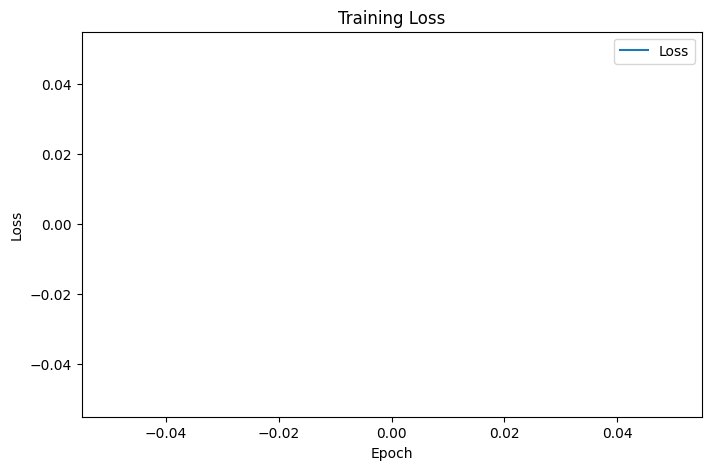

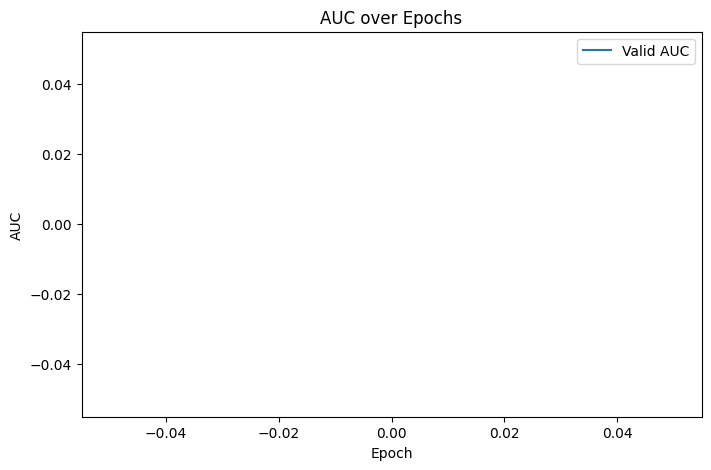

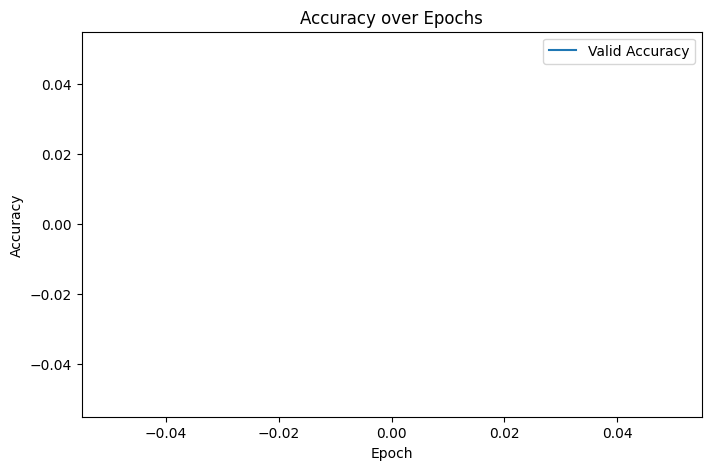

ValueError: not enough values to unpack (expected 2, got 1)

In [24]:
# 1️⃣ Loss
plt.figure(figsize=(8,5))
plt.plot(model.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2️⃣ AUC
plt.figure(figsize=(8,5))
plt.plot(model.history['valid_auc'], label='Valid AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# 3️⃣ Accuracy
plt.figure(figsize=(8,5))
plt.plot(model.history['valid_accuracy'], label='Valid Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Feature Importance Drift Smoothed + Non Smoothed
def plot_fi(fi, title="TabNet Feature Importances Over Training", feats=features):
    """fi should have shape (epochs, #numfeatures)"""
    num_epochs, num_features = fi.shape
    assert num_features==len(feats)
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 8))

    for feature_idx in range(num_features):
        plt.plot(epochs, fi[:, feature_idx], label=f"Feature {feats[feature_idx]}")

    plt.xlabel("Epoch")
    plt.ylabel("Feature Importance")
    plt.title(title)
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()  
from scipy.ndimage import gaussian_filter1d
fi = np.array(model.feature_importances_history)
plot_fi(fi, feats=features)
fi_smooth = gaussian_filter1d(fi, sigma=1.2, axis=0)
plot_fi(fi_smooth, title="Smoothed TabNet Feature Importances over Epochs", feats=features)

torch.save(fi, "feature_importance_drift_over_epochs")

Pick an Epoch (Reload model here if it crashes during influence)

In [25]:
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
epoch=46
epoch_path = f"models_/epoch_{epoch}.zip"
tabnet_classifier_params={
                'n_d': 16,
                'n_a': 16,
                'n_steps': 7,
                'gamma': 1.65,
                'lambda_sparse': 1e-3,
                'momentum': 0.015,
                "cat_idxs":cat_idxs,
                "cat_dims":cat_dims,
                "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
                "optimizer_fn":torch.optim.Adam,
                "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
                "scheduler_params":{    "step_size":15,
                                        "gamma": 0.35},
                "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                "mask_type":'entmax', # "sparsemax"
                }
model=TabNetClassifier(**tabnet_classifier_params)
model.load_model(epoch_path)


/Users/juliettegarcia/Documents/localToGlobalExpProject/TrustWorthyXAILocaltoGlobal/utilities/models/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


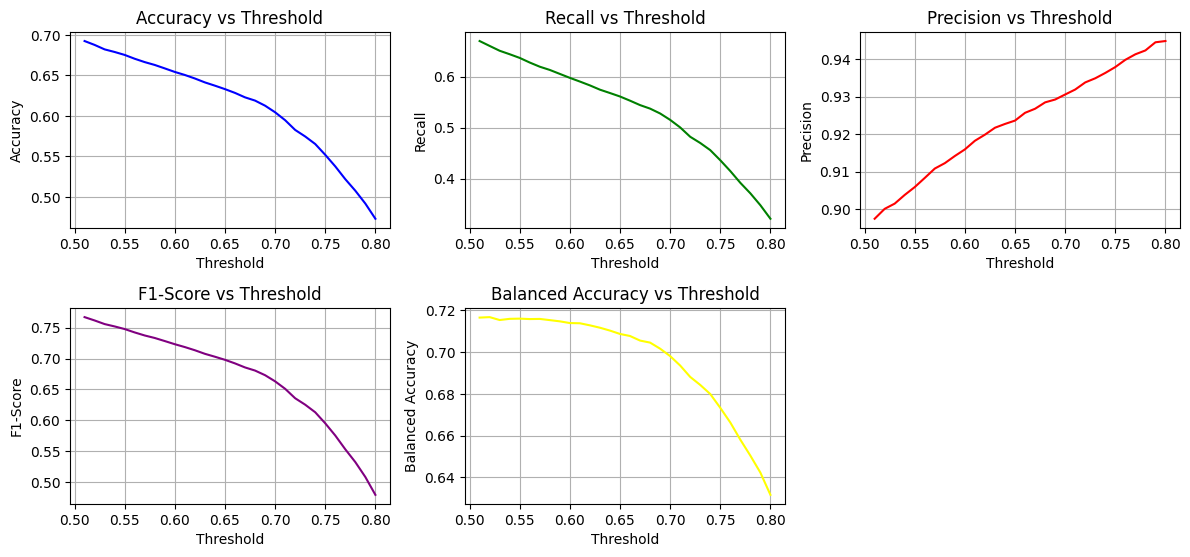

FINAL TEST SCORE for threshold 0.58:
Accuracy: 0.6629926143090714
Recall: 0.6130175307721
Precision: 0.9122953094643352
F1-Score: 0.7332961517010597


In [26]:

#Prediction:
from sklearn.metrics import confusion_matrix
thresholds=[0.5+j*0.01 for j in range(1, 31)]
accuracies = []
recalls = []
precisions = []
f1_scores = []
balanced_accs=[]
for threshold in thresholds:
    y_pred=model.predict(X_test, threshold=threshold)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy=(tn+tp)/(tn+fp+fn+tp)
    recall=tp / (tp + fn)
    precision=tp / (tp + fp)
    specificity=tn/(tn+fp)
    f1score=2*(precision*recall)/(precision+recall)
    balanced_acc=(recall+specificity)/2
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1score)
    balanced_accs.append(balanced_acc)
# Plot the metrics
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(3, 3, 1)
plt.plot(thresholds, accuracies, label='Accuracy', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.grid(True)

# Recall
plt.subplot(3, 3, 2)
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)

# Precision
plt.subplot(3, 3, 3)
plt.plot(thresholds, precisions, label='Precision', color='red')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)

# F1-Score
plt.subplot(3, 3, 4)
plt.plot(thresholds, f1_scores, label='F1-Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.grid(True)

#Balanced-Accuracy
plt.subplot(3, 3, 5)
plt.plot(thresholds, balanced_accs, label='Balanced Accuracy', color='yellow')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Threshold')
plt.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()
for j in range(len(thresholds)):
    #print(f"Threshhold {thresholds[j]}: Accuracy: {accuracies[j]}. Recall: {recalls[j]}. precisions: {precisions[j]}. f1_scores: {f1_scores[j]}. balanced_accs: {balanced_accs[j]}")
    pass
# Print the final score for the chosen threshold (e.g., 0.6 or whichever you prefer)
final_threshold = 0.58
final_index = thresholds.index(final_threshold)

print(f"FINAL TEST SCORE for threshold {final_threshold}:")
print(f"Accuracy: {accuracies[final_index]}")
print(f"Recall: {recalls[final_index]}")
print(f"Precision: {precisions[final_index]}")
print(f"F1-Score: {f1_scores[final_index]}")

In [27]:
#Explanations
importances=model.feature_importances_
feature_expl_stats=pd.DataFrame({'feature': features,
                                 'importance': model.feature_importances_,
                                 'Missing/Exempt percentage': [missing_val_info['count'][feature] if feature in missing_val_info['count'] else 0 for feature in features]
})
feature_expl_stats=feature_expl_stats.sort_values(by='importance', ascending=False)
print(feature_expl_stats)
print(f"Total number of parameters: {sum(p.numel() for p in model.network.parameters())}")

AttributeError: 'TabNetClassifier' object has no attribute 'feature_importances_'

In [28]:
model.network.cpu()
model.feature
with open("tabnet_model.pkl", "wb") as f:
    pickle.dump(model, f)

AttributeError: 'TabNetClassifier' object has no attribute 'feature'

In [29]:
outdir = "outdir/influences.csv"
df = pd.read_csv(outdir, skiprows=1, header=None, names=['train_id', 'test_id', 'influences'])
computed_pairs = set(zip(df['train_id'].astype(int), df['test_id'].astype(int)))
print(f"Already computed {len(computed_pairs)} pairs.")

Already computed 0 pairs.


Reload the model if it crashes or if not training again

In [30]:
from torch.utils.data import DataLoader, TensorDataset
from utilities.influence.calc_influence_function import precompute_s_tests 
from utilities.influence.utils import init_logging, get_default_config
import torch
import torch.nn as nn
import datetime
import logging
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
torch.autograd.set_detect_anomaly(True)
# tabnet_classifier_params={
#                 'n_d': 16,
#                 'n_a': 16,
#                 'n_steps': 7,
#                 'gamma': 1.45,
#                 'lambda_sparse': 2e-3,
#                 'momentum': 0.025,
#                 "cat_idxs":cat_idxs,
#                 "cat_dims":cat_dims,
#                 "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
#                 "optimizer_fn": torch.optim.Adam,
#                 "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
#                 "scheduler_params":{    "step_size":10,
#                                         "gamma": 0.68},
#                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
#                 "mask_type":'entmax', # "sparsemax"
#                 }
# model=TabNetClassifier(**tabnet_classifier_params)
# model.load_model('test_model.zip')
# assert(model.cat_idxs==cat_idxs)
#device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
#model.network.to(device)

class TabNetWrapper(nn.Module):
    """Wrapper to extract logits from TabNet's tuple output"""
    def __init__(self, tabnet_network):
        super().__init__()
        self.tabnet_network = tabnet_network
    
    def forward(self, x):
        output = self.tabnet_network(x)
        # TabNet returns (output, mask) tuple, extract just the logits
        if isinstance(output, tuple) and len(output)==2:
            return output[0]  # Return logits (first element)
        return output  # If not a tuple, return as-is
torch_model = TabNetWrapper(model.network)
torch_model.eval()

TabNetWrapper(
  (tabnet_network): TabNet(
    (embedder): EmbeddingGenerator(
      (embeddings): ModuleList(
        (0-2): 3 x Embedding(3, 1)
        (3): Embedding(2, 1)
        (4): Embedding(418, 15)
        (5): Embedding(4, 2)
        (6): Embedding(3, 1)
        (7): Embedding(2, 1)
        (8): Embedding(6, 2)
        (9): Embedding(4, 2)
        (10): Embedding(6, 2)
        (11): Embedding(4, 2)
        (12-15): 4 x Embedding(3, 1)
        (16): Embedding(2, 1)
        (17): Embedding(3, 1)
        (18): Embedding(55, 7)
      )
    )
    (tabnet): TabNetNoEmbeddings(
      (initial_bn): BatchNorm1d(44, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (encoder): TabNetEncoder(
        (initial_bn): BatchNorm1d(44, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (initial_splitter): FeatTransformer(
          (shared): GLU_Block(
            (shared_layers): ModuleList(
              (0): Linear(in_features=44, out_features=64, 

In [31]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=0)

## Influence Function (Time intensive, use cached computations and Run the following cell)

In [32]:
logging.disable(logging.DEBUG)

#calculate average influence of a single training point by sampling 1000 points
#test_indices=random.sample(range(1, len(X_test)), 1000)
test_indices=[25314, 1032, 33806, 9544, 27816, 20854, 22479, 11190, 20213, 28796, 21761, 19980, 5542, 22380, 13777, 10463, 24688, 27207, 6225, 4805, 21492, 10373, 29545, 13625, 25742, 11370, 10875, 4010, 22774, 11025, 7836, 16764, 375, 12859, 11854, 31922, 6653, 21786, 19390, 6321, 2635, 16678, 12756, 18794, 25884, 15908, 14798, 6642, 8475, 6236, 5023, 11401, 8545, 3414, 25533, 13361, 32975, 17018, 29708, 22686, 5973, 17349, 33144, 33581, 23775, 6614, 19655, 2824, 32415, 19474, 7357, 23357, 2870, 1206, 34720, 1561, 24474, 21274, 21278, 18659, 28202, 7815, 9278, 31391, 12915, 16384, 6519, 33741, 23839, 10174, 30079, 23306, 913, 1657, 7844, 7667, 8214, 18817, 13065, 13010, 28681, 22349, 8024, 6540, 7310, 15047, 23194, 32929, 15455, 11785, 33487, 26799, 20648, 8134, 16758, 17817, 27991, 3299, 13407, 24993, 17129, 409, 5657, 2540, 24035, 23351, 14265, 30163, 12026, 20541, 11010, 32369, 6484, 3788, 14146, 14581, 9176, 9368, 11155, 33654, 12408, 31233, 19777, 12474, 21810, 32534, 19285, 24258, 31265, 13009, 20482, 18862, 22521, 8552, 25973, 8345, 11902, 32565, 33442, 23913, 2137, 12063, 29151, 12620, 10946, 12785, 28656, 23869, 9690, 3425, 8982, 15019, 23562, 17814, 31991, 17569, 1873, 17419, 12838, 21407, 741, 30440, 14889, 9491, 21501, 18344, 22050, 14106, 16377, 25188, 31790, 331, 33483, 25762, 26150, 33989, 25042, 27221, 148, 18629, 33694, 11722, 5631, 9566, 22362, 18376, 24498, 28940, 21320, 19902, 23249, 20270, 26367, 22595, 15776, 7164, 19094, 32439, 376, 10325, 20784, 12721, 2301, 9905, 19246, 30474, 26596, 10587, 7550, 28280, 32057, 13178, 10428, 20364, 22977, 34728, 5815, 28995, 16637, 33289, 20771, 3568, 6490, 18117, 578, 18710, 15895, 30840, 6921, 6497, 27560, 22467, 22743, 967, 19271, 26822, 11915, 883, 29516, 20041, 2736, 29431, 34955, 16263, 32702, 16701, 9079, 535, 24957, 11463, 34673, 11162, 23260, 17127, 12776, 16010, 26586, 22318, 12206, 2300, 4783, 3551, 7967, 26807, 33432, 29685, 29510, 25823, 24304, 20809, 22965, 7905, 25738, 33392, 1609, 19689, 17843, 23583, 23536, 22372, 26322, 26496, 8171, 27485, 7394, 20763, 29386, 7166, 9605, 22734, 18009, 7152, 15250, 25859, 16333, 19664, 7326, 34002, 27872, 28246, 28507, 27719, 7207, 30257, 30736, 31717, 19872, 27627, 13554, 8140, 28210, 12129, 6571, 18002, 20001, 22707, 21176, 829, 12007, 28330, 12933, 29378, 11220, 6179, 13534, 5990, 2964, 29779, 34038, 2283, 6108, 22416, 10267, 30442, 10163, 4472, 14035, 30377, 25186, 12494, 6678, 29045, 2452, 21287, 10790, 23624, 11369, 15627, 8100, 10912, 31630, 32043, 2685, 26329, 28043, 13457, 32860, 2491, 21202, 27353, 19464, 24132, 14757, 27632, 18481, 2297, 5786, 19274, 23339, 31293, 32496, 1900, 13768, 34041, 17116, 1247, 8324, 1668, 22151, 23122, 24160, 8150, 16634, 7819, 1175, 7307, 34250, 501, 13545, 3933, 14657, 3912, 11860, 29259, 33650, 9331, 14336, 3761, 26365, 14520, 22613, 13257, 6606, 7830, 11106, 1990, 16799, 33482, 5547, 33910, 34965, 15206, 15198, 29044, 13702, 23071, 32015, 15636, 8648, 29290, 9253, 25913, 20656, 17434, 20101, 25359, 6738, 1644, 3713, 21350, 6115, 9439, 27686, 21991, 32579, 603, 7358, 4415, 7717, 21126, 33829, 13874, 34122, 12457, 896, 34733, 3668, 15225, 6268, 27070, 5875, 7177, 30944, 23668, 22008, 30886, 31513, 29940, 10551, 529, 32956, 6495, 30414, 23445, 21992, 32669, 21114, 13393, 23428, 27825, 31120, 32393, 30689, 11899, 5404, 27854, 9358, 11107, 25372, 29728, 13836, 3700, 20244, 9031, 33915, 21149, 31909, 34959, 2242, 7386, 605, 19461, 4904, 2644, 30266, 28506, 19109, 7784, 31135, 5123, 17725, 18551, 24011, 6455, 9967, 34141, 4838, 13502, 7035, 2052, 18215, 287, 2727, 5303, 2235, 8919, 28802, 13428, 25446, 20341, 2605, 9683, 11390, 2892, 24240, 19573, 25684, 24829, 34494, 9337, 608, 16662, 19381, 2259, 22542, 16980, 19477, 21903, 16687, 13074, 11180, 27358, 5141, 26072, 12062, 17183, 22159, 33820, 32004, 13686, 12576, 9482, 2686, 27230, 11818, 34443, 8834, 15085, 2138, 18658, 16084, 18903, 13867, 17580, 26571, 4114, 19989, 18511, 2804, 34311, 14096, 4596, 10978, 30803, 10997, 11514, 17959, 25649, 20191, 29949, 10769, 21115, 13689, 26046, 34847, 13576, 6208, 10450, 27512, 31616, 15633, 16370, 23698, 24131, 6009, 25450, 24956, 16572, 310, 10574, 10778, 26399, 6276, 26530, 23783, 6087, 13520, 12473, 23519, 34558, 33320, 7000, 25293, 16234, 27984, 7521, 32651, 22232, 8351, 33669, 5318, 24739, 25695, 30906, 32621, 5703, 19367, 31888, 25746, 2557, 11455, 14698, 5733, 10716, 17496, 11084, 28923, 17212, 7137, 13776, 9637, 18981, 27552, 10001, 27836, 21971, 13892, 5187, 13437, 19247, 3923, 31180, 4617, 14965, 6052, 22162, 1242, 12405, 31727, 26987, 3809, 20055, 1985, 3978, 34563, 24169, 31663, 17225, 16356, 31545, 25387, 21171, 26601, 28736, 32566, 292, 25842, 17589, 34713, 19002, 18086, 19550, 6094, 12653, 32325, 12823, 33931, 27298, 27656, 25688, 31300, 34657, 33327, 20908, 33109, 1201, 2754, 18318, 19618, 8999, 19249, 32558, 5782, 34627, 16270, 31463, 9978, 12, 18807, 448, 11983, 28153, 11418, 27282, 29185, 27356, 13667, 27414, 20009, 17532, 32928, 30539, 3637, 23663, 34409, 10998, 14173, 33440, 18645, 10007, 2796, 30744, 24318, 2182, 10237, 22376, 19952, 16134, 29184, 24548, 10566, 29720, 26111, 32983, 19919, 34302, 23192, 24015, 14858, 33614, 18661, 27999, 11984, 23476, 14385, 16103, 4705, 1272, 31330, 14978, 33876, 3255, 20058, 2038, 25141, 25379, 5807, 7008, 4476, 29774, 23341, 21358, 3736, 33303, 23177, 28331, 2390, 16449, 9872, 15317, 30227, 22288, 6632, 30718, 12098, 9754, 1012, 33643, 23997, 15752, 1911, 2724, 33597, 25944, 5691, 21477, 18467, 2221, 16415, 25898, 3341, 5598, 705, 14344, 10023, 17300, 23285, 24725, 27861, 17858, 2631, 987, 32433, 15479, 8941, 21485, 5645, 29165, 12375, 13134, 3203, 33826, 1117, 1849, 30649, 13132, 12598, 25770, 26976, 15093, 5231, 4201, 4096, 2276, 2126, 12514, 20039, 12677, 1689, 26407, 8993, 21457, 567, 21969, 5301, 17440, 34156, 11573, 16754, 3426, 28034, 16583, 20819, 5776, 3792, 33135, 16826, 18559, 16516, 25297, 30175, 12500, 22574, 9630, 20632, 30071, 680, 11365, 5716, 23968, 10351, 34567, 28596, 33889, 15526, 18008, 12695, 4842, 32886, 18121, 18106, 33927, 19445, 26995, 10586, 32021, 13806, 22839, 29332, 28253, 5293, 34447, 2942, 33430, 26709, 17247, 31703, 2022, 18281, 26702, 25191, 5503, 20689, 6850, 2250, 32216, 26092, 7380, 14573, 27961, 33226, 21321, 19798, 32775, 33093, 10184, 815, 15330, 23694, 1023, 30270, 15737, 16116, 26064, 26954, 4366, 13068, 31661, 18284, 2210, 26824, 3170, 1340, 8916, 23278, 7660, 34142, 18478, 13743, 14517, 28412, 14055, 27017, 13123, 20960, 14395, 26654, 6082, 10595, 21086, 22222, 18334, 10605, 29051, 18797, 13421, 19264, 347, 23904, 3037, 4483, 1245, 20303, 10054, 8354, 30416, 1974, 15743, 13928, 12236, 642, 23613, 17400, 9484, 28467, 8711, 25333, 4812, 30926, 22506]

In [33]:
# Configure and run influence calculation (This takes long don't run!!!)
init_logging()
config = {
        'outdir': 'outdir',
        'seed': 42,
        'device': 0 if torch.cuda.is_available() else -1,
        'dataset': '2024LAR',
        'num_classes': 2,
        'test_sample_num': False,
        'test_start_index': False,
        'recursion_depth': 90, #Need higher recursion_depth, note 1 recursion takes approximately 0.
        'r_averaging': 1, #Note experimentation shows that r_averaging has minimal effect can keep to a low number like 1-3
        'scale': 1000,
        'damp': 0.08,
        'log_filename': 'test_influence_log',
    }

#First we will precompute the s_test here:
precompute_s_tests(model=torch_model, test_loader=test_loader, train_loader=train_loader, test_ids=test_indices, config=config, eps=2e-4, patience=5)


[skip] s_test for idx 25314 already exists.
[skip] s_test for idx 1032 already exists.
[skip] s_test for idx 33806 already exists.
[skip] s_test for idx 9544 already exists.
[skip] s_test for idx 27816 already exists.
[skip] s_test for idx 20854 already exists.
[skip] s_test for idx 22479 already exists.
[skip] s_test for idx 11190 already exists.
[skip] s_test for idx 20213 already exists.
[skip] s_test for idx 28796 already exists.
[skip] s_test for idx 21761 already exists.
[skip] s_test for idx 19980 already exists.
[skip] s_test for idx 5542 already exists.
[skip] s_test for idx 22380 already exists.
[skip] s_test for idx 13777 already exists.
[skip] s_test for idx 10463 already exists.
[skip] s_test for idx 24688 already exists.
[skip] s_test for idx 27207 already exists.
[skip] s_test for idx 6225 already exists.
[skip] s_test for idx 4805 already exists.
[skip] s_test for idx 21492 already exists.
[skip] s_test for idx 10373 already exists.
[skip] s_test for idx 29545 already e

In [34]:
#generate the training indices
# training_indices = random.sample(range(1, 281500), 40000)
# np.savetxt("training_indices.csv", training_indices, delimiter=",", fmt="%d")

In [35]:
#Save pertrainbatch+testpt in case kernel dies...

config = {
        'outdir': 'outdir',
        'seed': 42,
        'device': 0 if torch.cuda.is_available() else -1,
        'dataset': '2024LAR',
        'num_classes': 2,
        'test_sample_num': False,
        'test_start_index': False,
        'recursion_depth': 90, #Need higher recursion_depth, note 1 recursion takes approximately 0.
        'r_averaging': 1, #Note experimentation shows that r_averaging has minimal effect can keep to a low number like 1-3
        'scale': 1000,
        'damp': 0.08,
        'log_filename': 'test_influence_log',
    }
from utilities.influence.calc_influence_function import load_stest_and_compute_batch_influence
loaded_train_indices=np.loadtxt("training_indices.csv", delimiter=",", dtype=int).tolist()
load_stest_and_compute_batch_influence(model=torch_model, train_loader=train_loader, test_loader=test_loader, test_indices=test_indices, train_indices=loaded_train_indices, config=config, cachedir="s_test_cache", batchsize=1024)


Already computed 0 pairs.


KeyboardInterrupt: 

In [36]:
# Note: calc_total_influence_of_points_from_csv not needed - using pandas groupby instead
csv_file = os.path.join(project_root, "training", "outdir", "influences.csv")
df = pd.read_csv(csv_file)
avginfls=df.groupby("train_id")["influence"].mean().rename("total_influence")
print(avginfls.head(15))

Series([], Name: total_influence, dtype: object)


**Visualize Influence Results**

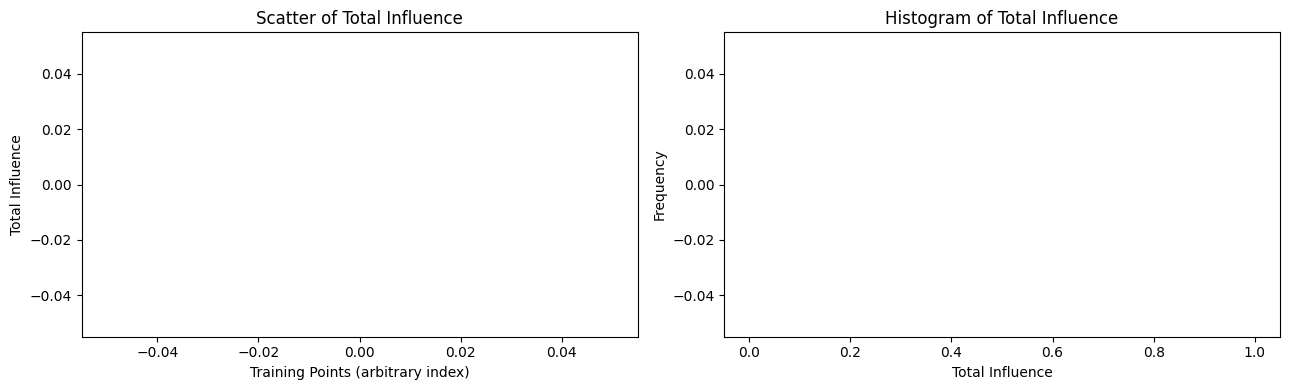

In [37]:
# Visualize Influence Results
# Check if avginfls exists
if 'avginfls' not in globals():
    print("Error: avginfls not found. Please run the previous cell first.")
    print("Loading from CSV...")
    csv_file = os.path.join(project_root, "training", "influences.csv")
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        avginfls = df.groupby("train_id")["influence"].mean().rename("total_influence") # mean influence of each training point
        print(f"Loaded {len(avginfls)} training samples from CSV")
    else:
        raise FileNotFoundError(f"CSV file not found at {csv_file}")

train_ids = avginfls.index.tolist()
influence_vals = np.array(avginfls.values.tolist())

# Scatter plot
plt.figure(figsize=(13,4))
plt.subplot(1, 2, 1)  # 1 row, 2 cols, first plot
y_coordinates = np.zeros_like(influence_vals) + np.random.uniform(-0.1, 0.1, len(influence_vals))
plt.scatter(y_coordinates, influence_vals, alpha=0.5, edgecolors='w', s=30)
plt.xlabel("Training Points (arbitrary index)")
plt.ylabel("Total Influence")
plt.title("Scatter of Total Influence")

# Histogram
plt.subplot(1, 2, 2)  # 1 row, 2 cols, second plot
plt.hist(influence_vals, bins=50, alpha=0.7, color='orange')
plt.xlabel("Total Influence")
plt.ylabel("Frequency")
plt.title("Histogram of Total Influence")

plt.tight_layout()
plt.show()


Empty DataFrame
Columns: [positive, negative]
Index: []


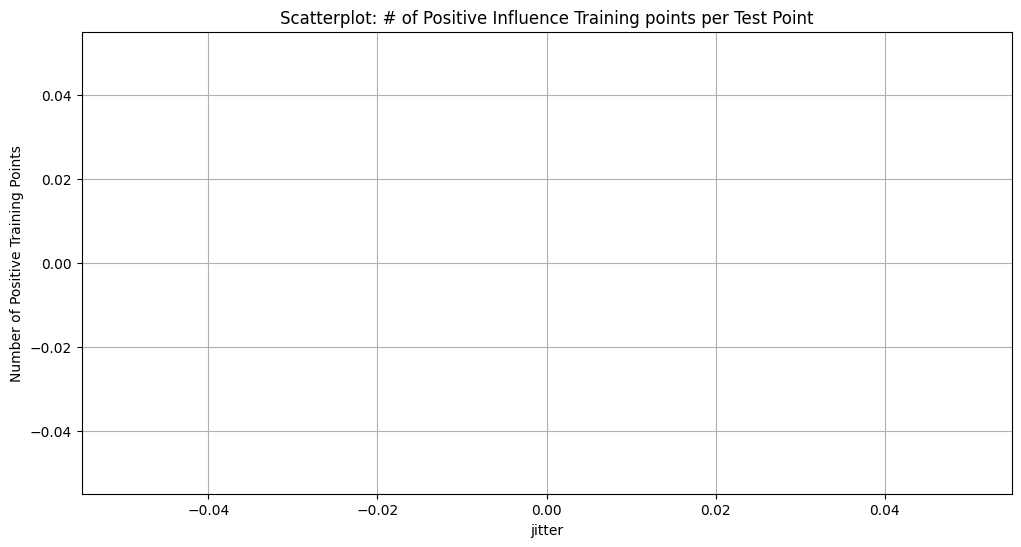

Text(0.5, 1.0, 'Histogram of Positive Training points per test')

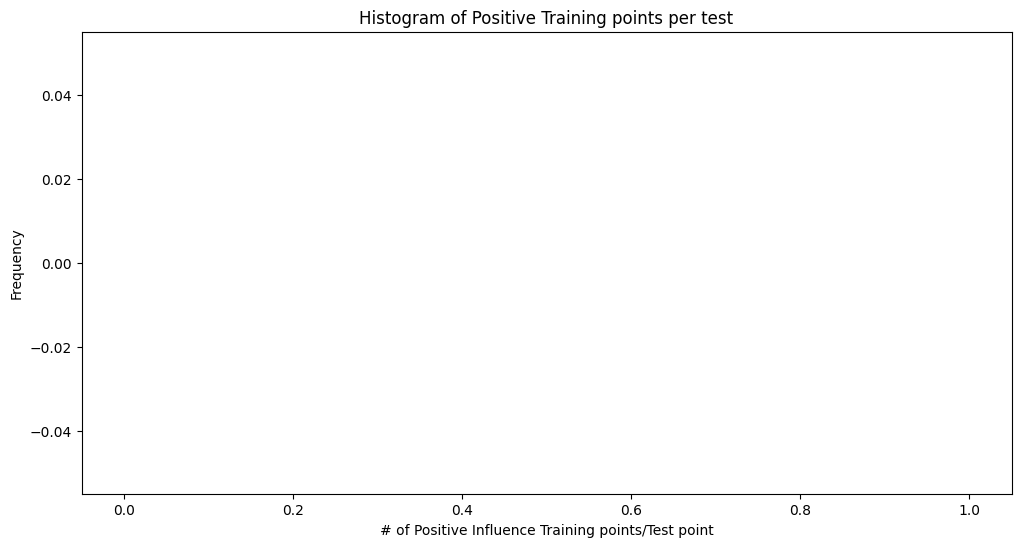

In [38]:
# Positive and harmful points
# Check if df exists, if not load from CSV
if 'df' not in globals():
    print("Loading CSV file...")
    csv_file = os.path.join(project_root, "training", "influences.csv")
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        print(f"Loaded {len(df)} rows from CSV")
    else:
        raise FileNotFoundError(f"CSV file not found at {csv_file}")

#Positive and harmful points:
df['positive'] = (df['influence'] >= 0).astype(int)
df['negative'] = (df['influence'] < 0).astype(int)
counts_dict = df.groupby('test_id')[['positive', 'negative']].sum()
print(counts_dict)

positive_counts=np.array(counts_dict['positive'].tolist())
test_ids=counts_dict.index.tolist()
plt.figure(figsize=(12,6))
y_coordinates = np.zeros_like(positive_counts) + np.random.uniform(-0.1, 0.1, len(positive_counts))
plt.scatter(y_coordinates, positive_counts, alpha=0.5, edgecolors='w', s=30)
plt.xlabel('jitter')
plt.ylabel('Number of Positive Training Points')
plt.title('Scatterplot: # of Positive Influence Training points per Test Point')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.hist(positive_counts, bins=60, alpha=0.7, color='orange')
plt.xlabel("# of Positive Influence Training points/Test point")
plt.ylabel("Frequency")
plt.title("Histogram of Positive Training points per test")



In [41]:
# Visualize Influence Results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def visualize_influence_results(influence_results, test_id=0, top_k=10, show_train_data=False):
    """
    Visualize influence results for a specific test sample.
    
    Args:
        influence_results: Dictionary returned by calc_influence_dataset
        test_id: Index of test sample to visualize
        top_k: Number of top helpful/harmful training samples to show
        show_train_data: If True, show actual feature values of training samples
    """
    if str(test_id) not in influence_results:
        print(f"Test ID {test_id} not found in results. Available IDs: {list(influence_results.keys())[:10]}")
        return
    
    result = influence_results[str(test_id)]
    influences = result['influence']
    harmful_indices = result['harmful'][:top_k]
    helpful_indices = result['helpful'][:top_k]
    
    # Create DataFrame for easier manipulation
    df = pd.DataFrame({
        'train_idx': range(len(influences)),
        'influence': influences
    })
    
    # Get top helpful and harmful
    helpful_df = df.loc[helpful_indices].copy()
    helpful_df = helpful_df.sort_values('influence', ascending=False)
    
    harmful_df = df.loc[harmful_indices].copy()
    harmful_df = harmful_df.sort_values('influence', ascending=True)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot harmful influences
    axes[0].barh(range(len(harmful_df)), harmful_df['influence'].values, color='coral', alpha=0.7)
    axes[0].set_yticks(range(len(harmful_df)))
    axes[0].set_yticklabels([f"Train {idx}" for idx in harmful_df['train_idx'].values])
    axes[0].set_xlabel('Influence Score (negative = harmful)', fontsize=11)
    axes[0].set_title(f'Top {top_k} Most Harmful Training Samples\n(Test Sample {test_id}, Label: {result["label"]})', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Plot helpful influences
    axes[1].barh(range(len(helpful_df)), helpful_df['influence'].values, color='lightgreen', alpha=0.7)
    axes[1].set_yticks(range(len(helpful_df)))
    axes[1].set_yticklabels([f"Train {idx}" for idx in helpful_df['train_idx'].values])
    axes[1].set_xlabel('Influence Score (positive = helpful)', fontsize=11)
    axes[1].set_title(f'Top {top_k} Most Helpful Training Samples\n(Test Sample {test_id}, Label: {result["label"]})', fontsize=12, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print(f"Influence Analysis Summary for Test Sample {test_id}")
    print(f"{'='*60}")
    print(f"Test Label: {result['label']}")
    print(f"Calculation Time: {result['time_calc_influence_s']:.2f} seconds")
    print(f"\nInfluence Statistics:")
    print(f"  Mean: {np.mean(influences):.6f}")
    print(f"  Std:  {np.std(influences):.6f}")
    print(f"  Min:  {np.min(influences):.6f}")
    print(f"  Max:  {np.max(influences):.6f}")
    print(f"\nMost Harmful Training Sample: {harmful_indices[0]} (influence: {influences[harmful_indices[0]]:.6f})")
    print(f"Most Helpful Training Sample: {helpful_indices[0]} (influence: {influences[helpful_indices[0]]:.6f})")
    
    # Optionally show training data for top samples
    if show_train_data and 'X_train' in globals():
        print(f"\n{'='*60}")
        print("Top Helpful Training Sample Features:")
        print(f"{'='*60}")
        top_helpful_idx = helpful_indices[0]
        top_helpful_features = pd.DataFrame({
            'feature': features,
            'value': X_train[top_helpful_idx]
        })
        print(top_helpful_features.to_string(index=False))
        
        print(f"\n{'='*60}")
        print("Top Harmful Training Sample Features:")
        print(f"{'='*60}")
        top_harmful_idx = harmful_indices[0]
        top_harmful_features = pd.DataFrame({
            'feature': features,
            'value': X_train[top_harmful_idx]
        })
        print(top_harmful_features.to_string(index=False))

# Visualize results for first test sample
if 'influence_results' in globals():
    visualize_influence_results(influence_results, test_id=0, top_k=10, show_train_data=True)
else:
    print("Run the influence calculation cell first")


Run the influence calculation cell first


## Local Rule Extraction using Influence Functions

**STANDALONE SECTION**: This section can be run independently using the `influences.csv` file generated from the influence function section above.

This section extracts human-readable local decision rules for TabNet predictions using influence functions. The pipeline:

1. **Identify Influential Training Samples**: Loads influences from CSV to find training points that support (S_plus) or oppose (S_minus) the prediction
2. **Cluster Influential Samples**: Groups influential samples by features, model predictions, and influence sign. Each of these clusters will be the "neighborhood" we will general a local rule set for (i.e. those are the points that will be used for training a decision tree).
3. **Derive Symbolic Rules**: Extracts decision tree rules from each cluster to explain "why" and "what if" scenarios

**Requirements:**
- `influences.csv` file (generated from influence function section)
- Trained model (`test_model.zip`)
- Training data (`X_train`, `y_train`, `features`) - can be loaded from memory or pickle file

These local rules are designed to be aggregated later into global rules (GLocalX-style).


In [42]:
# Local Rule Extraction Pipeline - Standalone Version
# This section can be run independently using the influences.csv file

# Setup Python path (required for imports)
import os
import sys
if 'project_root' not in globals():
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(project_root)
    print(f"✓ Added project root to path: {project_root}")

from utilities.influence.local_rule_extraction import LocalRuleExtractor
from utilities.models.pytorch_tabnet.tab_model import TabNetClassifier
import torch.nn as nn

# STEP 1: Load Required Data and Model
# ============================================================================

epoch=46
epoch_path = f"models_/epoch_{epoch}.zip"
tabnet_classifier_params={
                'n_d': 16,
                'n_a': 16,
                'n_steps': 7,
                'gamma': 1.65,
                'lambda_sparse': 1e-3,
                'momentum': 0.015,
                "cat_idxs":cat_idxs,
                "cat_dims":cat_dims,
                "cat_emb_dim":[min(15, int(j**0.5)) for j in cat_dims],
                "optimizer_fn":torch.optim.Adam,
                "optimizer_params":dict(lr=2e-3, weight_decay=3e-3),
                "scheduler_params":{    "step_size":15,
                                        "gamma": 0.35},
                "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                "mask_type":'entmax', # "sparsemax"
                }
model=TabNetClassifier(**tabnet_classifier_params)
model.load_model(epoch_path)
torch_model=TabNetWrapper(model.network)
torch_model.eval()

# Load training data (X_train, y_train, features)
# These should be available from previous cells, but we'll check
if 'X_train' not in globals() or 'features' not in globals():
    raise ValueError("X_train, y_train, and features not found. Run data processing cells first.")
else:
    print("Training data found in memory")


# STEP 2: Initialize Rule Extractor
# ============================================================================

rule_extractor = LocalRuleExtractor(
    model=torch_model,
    feature_names=features,
    n_clusters=6,  # Number of clusters for influential samples
    max_depth=4,   # Max depth for decision trees (keep shallow for interpretability)
    min_samples_split=10  # Minimum samples to split a node
)


Training data found in memory


/Users/juliettegarcia/Documents/localToGlobalExpProject/TrustWorthyXAILocaltoGlobal/utilities/models/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [43]:
# STEP 3: Load Influences from CSV and Extract Rules
# ============================================================================

# Path to the influences CSV file
csv_path = os.path.join(project_root, "training", "outdir", "influences.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Influences CSV not found at {csv_path}. Please run the influence calculation section first.")

# Check available test IDs in the CSV
import pandas as pd
df_influences = pd.read_csv(csv_path)  # Sample to check structure
print(df_influences.head(10))

# Get unique test IDs 
unique_test_ids = sorted(df_influences['test_id'].unique())
assert unique_test_ids==sorted(test_indices)
test_id = unique_test_ids[24]
print(f"Extracting local rules for test sample {test_id}")

# Extract rules from CSV
local_rules = rule_extractor.extract_local_rules_from_csv(
    csv_path=csv_path,
    test_id=test_id,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,  # Provide test set if available
    top_k=200,  # Number of top helpful/harmful samples to consider
    clustering_method='kmeans'  # or 'dbscan'
)
print(f"Number of Helpful Samples for testID {test_id} : {len(local_rules['helpful_samples'])}")
print(f"Number of Harmful Samples for testID {test_id} : {len(local_rules['harmful_samples'])}")
print(f"Number of Clusters: {local_rules['n_clusters']}")
print(f"{'='*70}")

# To analyze a different test sample, change test_id above and re-run this cell


Empty DataFrame
Columns: [train_id, test_id, influence]
Index: []


AssertionError: 

In [ ]:
# Visualize and Display Extracted Rules

def display_local_rules(local_rules, feature_names):
    """Display extracted local rules in a human-readable format."""
    print(f"LOCAL EXPLANATION RULES FOR TEST SAMPLE {local_rules['test_id']}")
    print(f"{'='*70}")
    print(f"Model Prediction: Class {local_rules['test_prediction']}")
    
    for cluster_id, cluster_info in local_rules['clusters'].items():
        if cluster_info['n_samples'] < 5:  # Skip very small clusters
            continue
            
        print(f"\n{'─'*70}")
        print(f"CLUSTER {cluster_id}")
        print(f"{'─'*70}")
        print(f"  Samples: {cluster_info['n_samples']}")
        print(f"  Dominant Label: {cluster_info['dominant_label']}")
        print(f"  Mean Influence: {cluster_info['mean_influence']:.6f}")
        
        if cluster_info.get('explanation_rule') is None:
            print(f"\n  ⚠️  WARNING: Could not extract explanation rule for this cluster.")
            print(f"     This may indicate the cluster is too homogeneous or the tree structure is complex.")
        elif cluster_info['explanation_rule']:
            print(f"\n  📋 EXPLANATION RULE (Why this prediction?):")
            print(f"     {cluster_info['explanation_rule']}")
        
        if cluster_info.get('counterfactual_rule') is None:
            print(f"\n  ℹ️  No counterfactual rule available (no opposing clusters found)")
        elif cluster_info['counterfactual_rule']:
            print(f"\n  🔄 COUNTERFACTUAL RULE (What needs to change?):")
            print(f"     {cluster_info['counterfactual_rule']}")
    
    print(f"\n{'='*70}")
    print("Note: These local rules can be aggregated across many instances")
    print("to discover global patterns (future: GLocalX-style aggregation)")
    print(f"{'='*70}\n")

# Display rules if available
if 'local_rules' in globals():
    display_local_rules(local_rules, features)
else:
    print("No local rules found. Please run the rule extraction cell first.")


LOCAL EXPLANATION RULES FOR TEST SAMPLE 829
Model Prediction: Class 0

──────────────────────────────────────────────────────────────────────
CLUSTER 0
──────────────────────────────────────────────────────────────────────
  Samples: 50
  Dominant Label: 0
  Mean Influence: 0.006574

  📋 EXPLANATION RULE (Why this prediction?):
     IF derived_msa_md <= 242.5800 AND state_code <= 30.0000 AND loan_purpose <= 1.1200 THEN class = 0

  ℹ️  No counterfactual rule available (no opposing clusters found)

──────────────────────────────────────────────────────────────────────
CLUSTER 1
──────────────────────────────────────────────────────────────────────
  Samples: 104
  Dominant Label: 1
  Mean Influence: -0.006074

  📋 EXPLANATION RULE (Why this prediction?):
     IF derived_msa_md <= 252.4423 AND state_code <= 26.6538 AND loan_purpose <= 2.0962 THEN class = 1

  ℹ️  No counterfactual rule available (no opposing clusters found)

───────────────────────────────────────────────────────────────


CLUSTER 0 - DECISION TREE VISUALIZATION

📊 Decision Tree Structure (Text Format):
──────────────────────────────────────────────────────────────────────
|--- loan_type <= 0.50
|   |--- derived_msa_md <= 358.50
|   |   |--- class: 0
|   |--- derived_msa_md >  358.50
|   |   |--- class: 0
|--- loan_type >  0.50
|   |--- class: 1


📈 Decision Tree Visualization:


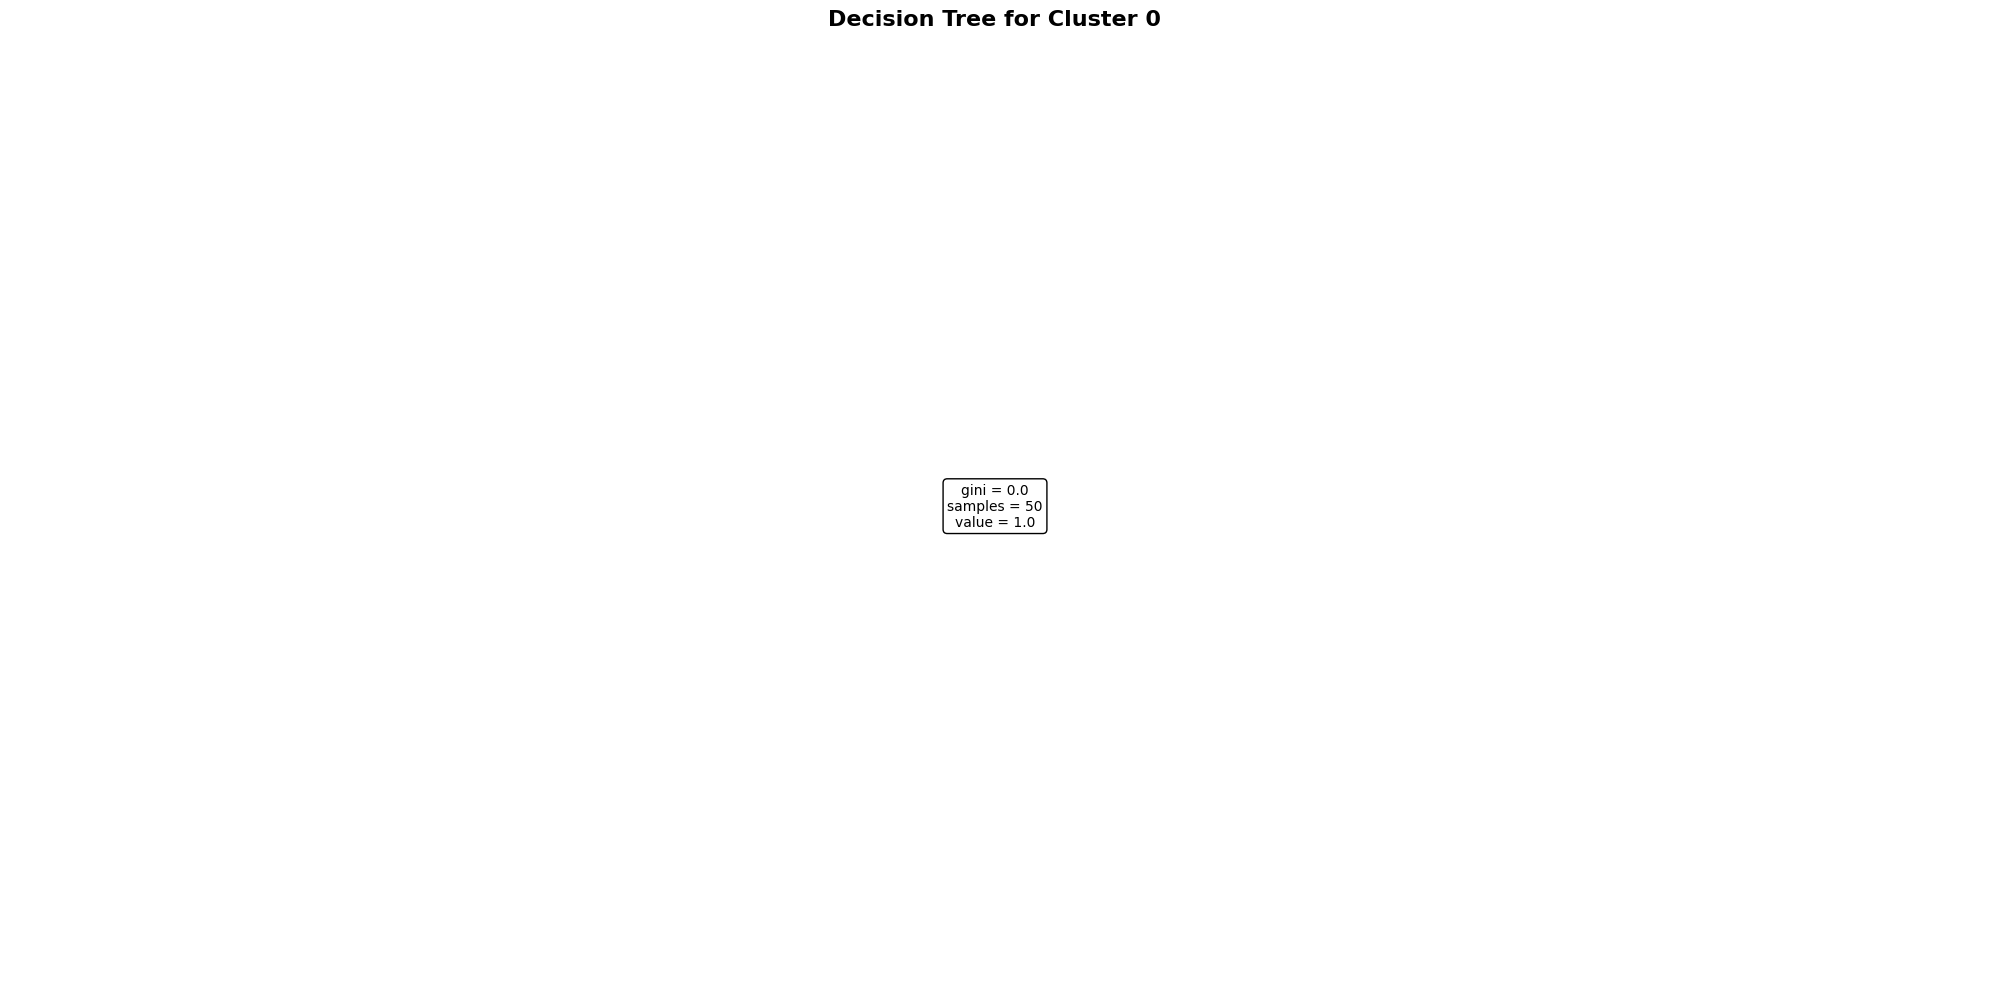


🔍 Sample Path Analysis:
──────────────────────────────────────────────────────────────────────
Random sample from cluster (index 148247):
  True Label: 1
  Predicted Label: 0
  Leaf Node: 0
  Leaf Class: 0
  Samples in Leaf: 1

  Path through tree:
    1. loan_type <= 0.5000 (value: 0.0000)
    2. derived_msa_md <= 358.5000 (value: 171.0000)

  Full Path: loan_type <= 0.5000 → derived_msa_md <= 358.5000 → Class 0



CLUSTER 1 - DECISION TREE VISUALIZATION

📊 Decision Tree Structure (Text Format):
──────────────────────────────────────────────────────────────────────
|--- state_code <= 45.00
|   |--- state_code <= 38.00
|   |   |--- class: 0
|   |--- state_code >  38.00
|   |   |--- class: 0
|--- state_code >  45.00
|   |--- class: 1


📈 Decision Tree Visualization:


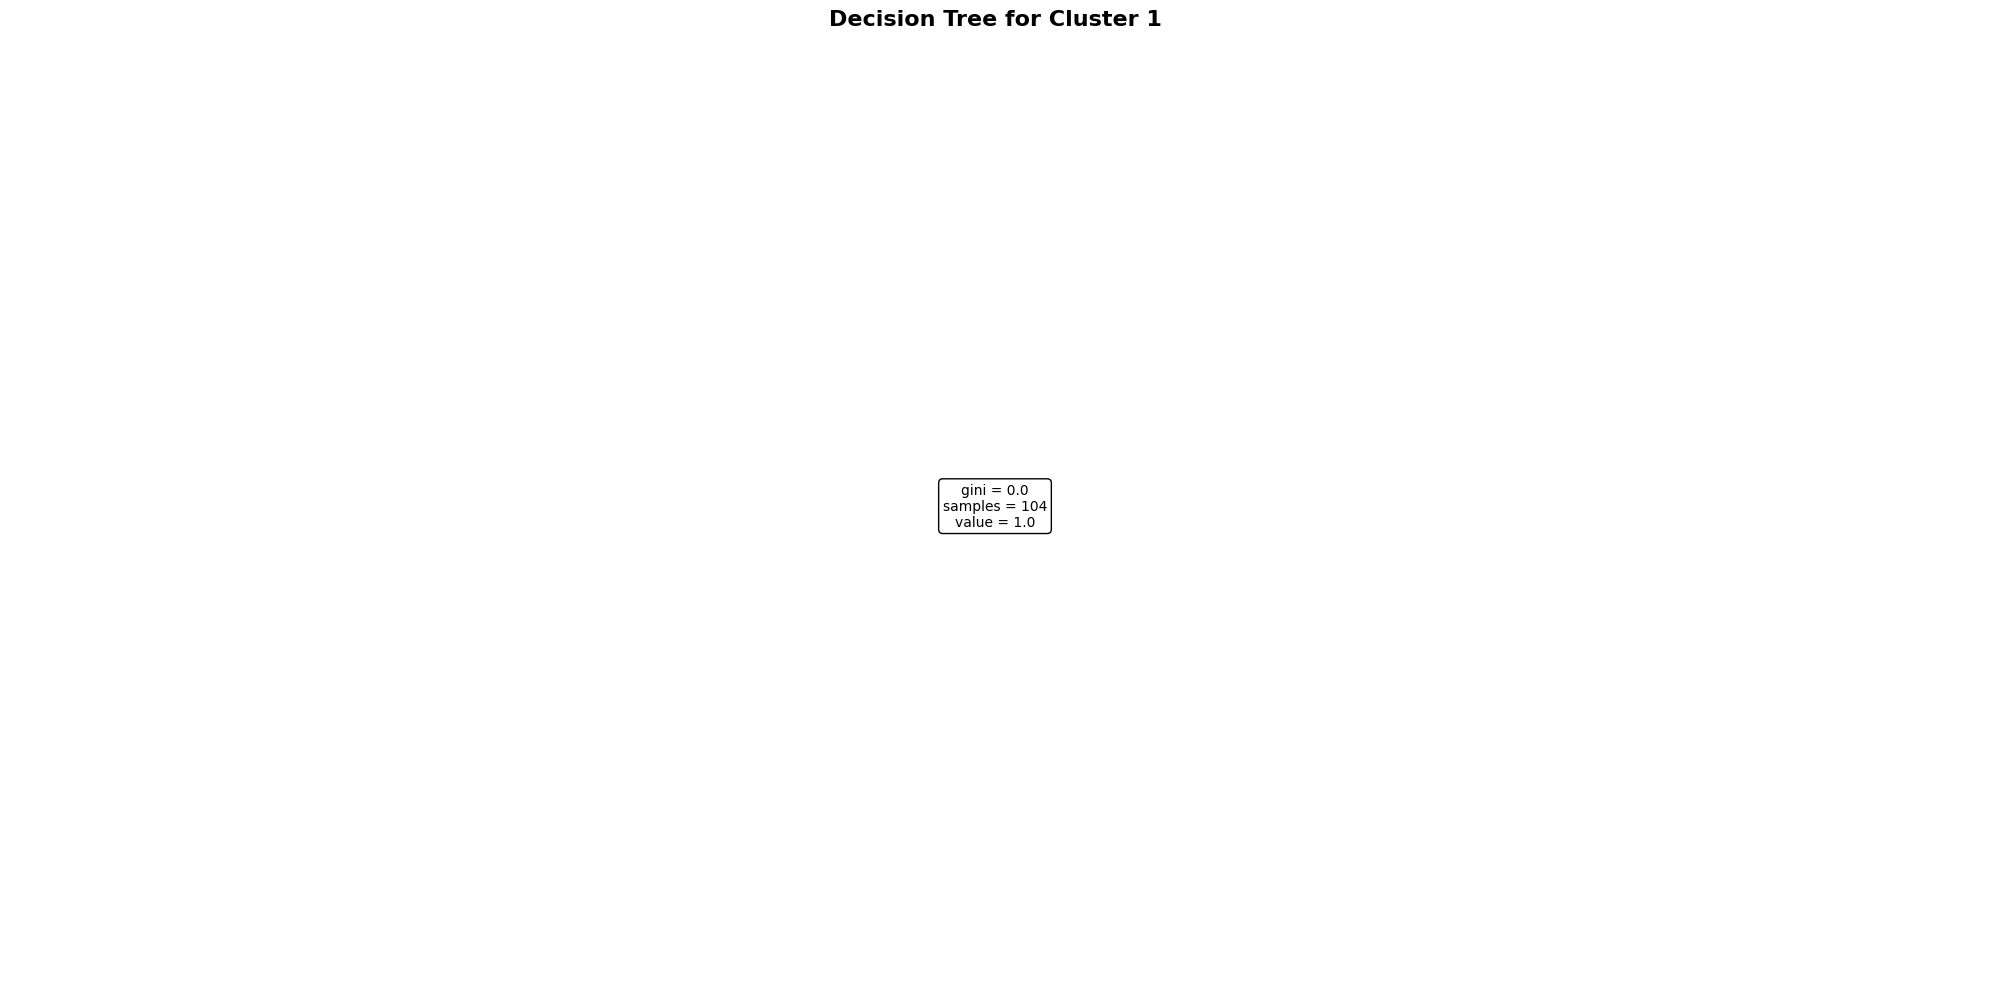


🔍 Sample Path Analysis:
──────────────────────────────────────────────────────────────────────
Random sample from cluster (index 12305):
  True Label: 1
  Predicted Label: 1
  Leaf Node: 0
  Leaf Class: 0
  Samples in Leaf: 1

  Path through tree:
    1. state_code <= 45.0000 (value: 35.0000)
    2. state_code <= 38.0000 (value: 35.0000)

  Full Path: state_code <= 45.0000 → state_code <= 38.0000 → Class 0



CLUSTER 2 - DECISION TREE VISUALIZATION

📊 Decision Tree Structure (Text Format):
──────────────────────────────────────────────────────────────────────
|--- derived_msa_md <= 35.50
|   |--- class: 0
|--- derived_msa_md >  35.50
|   |--- state_code <= 12.00
|   |   |--- state_code <= 7.50
|   |   |   |--- class: 1
|   |   |--- state_code >  7.50
|   |   |   |--- class: 0
|   |--- state_code >  12.00
|   |   |--- occupancy_type <= 0.50
|   |   |   |--- state_code <= 42.00
|   |   |   |   |--- class: 1
|   |   |   |--- state_code >  42.00
|   |   |   |   |--- class: 1
|   |   |--- 

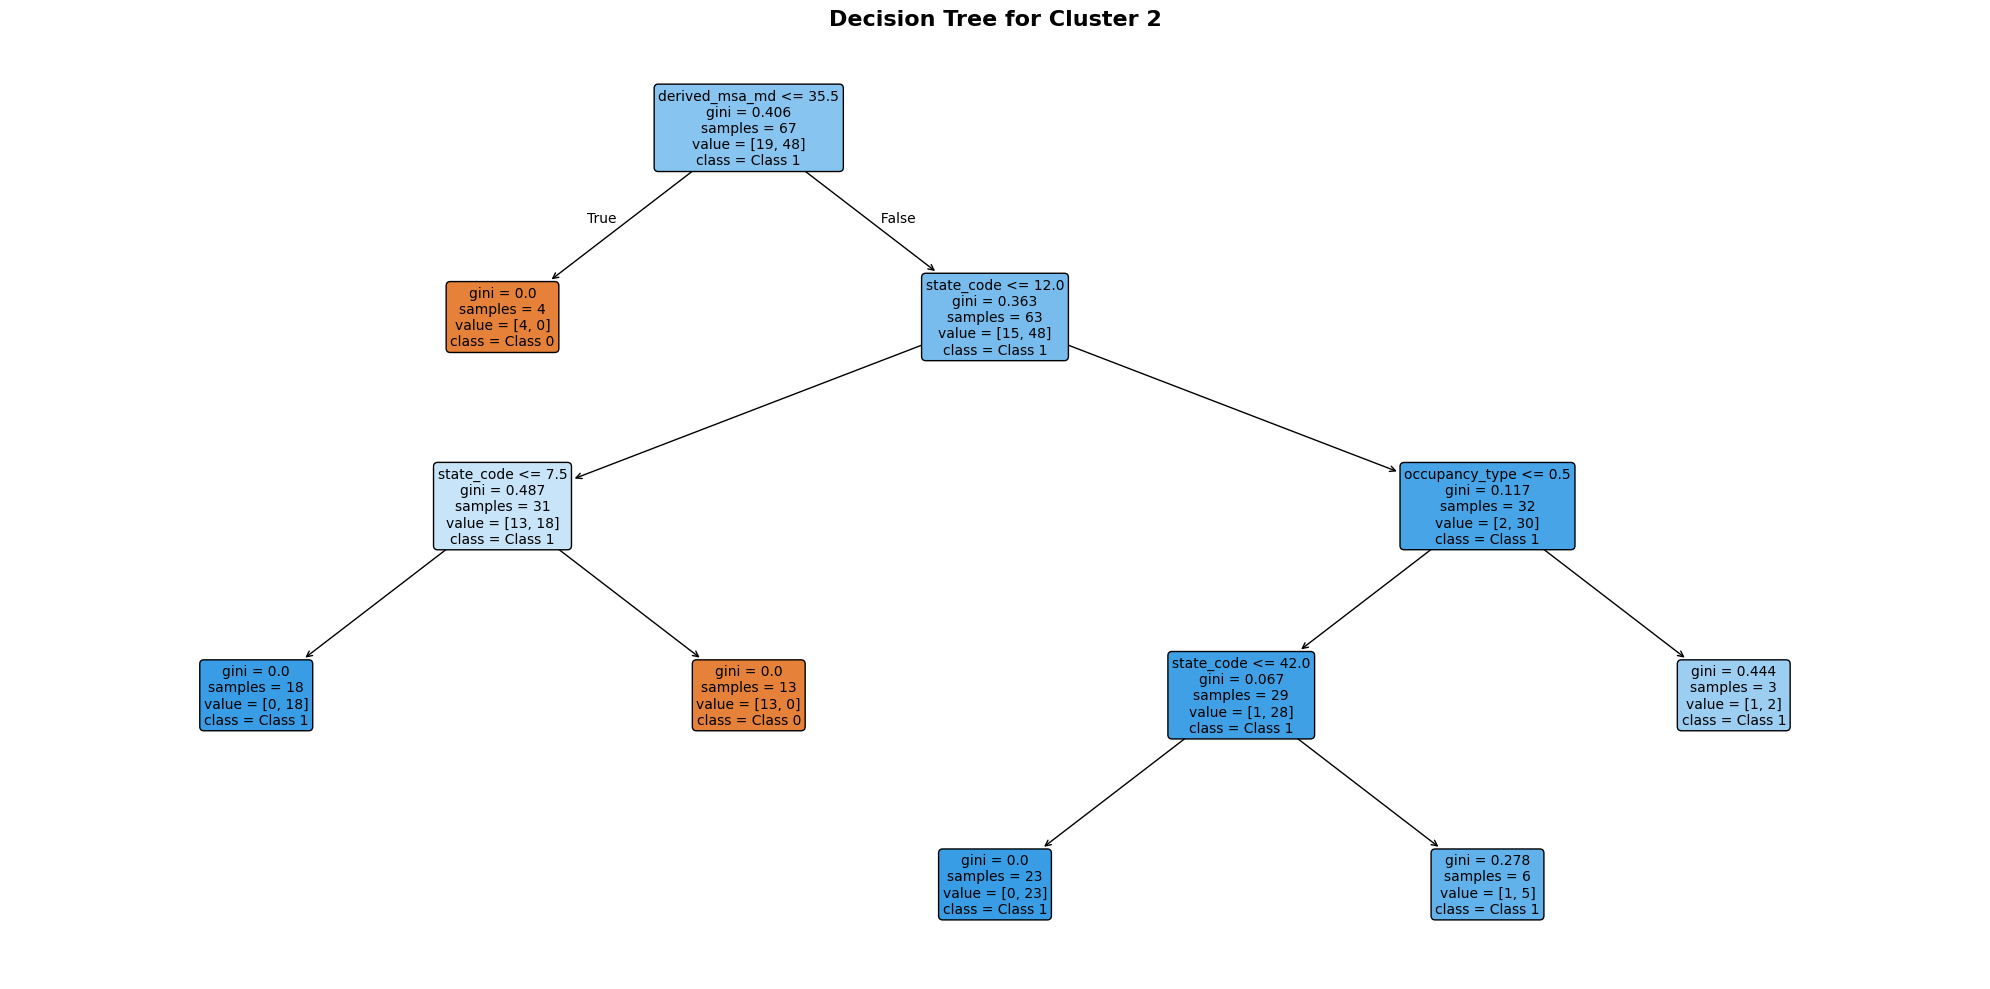


🔍 Sample Path Analysis:
──────────────────────────────────────────────────────────────────────
Random sample from cluster (index 277163):
  True Label: 0
  Predicted Label: 1
  Leaf Node: 8
  Leaf Class: 1
  Samples in Leaf: 1

  Path through tree:
    1. derived_msa_md > 35.5000 (value: 45.0000)
    2. state_code > 12.0000 (value: 14.0000)
    3. occupancy_type <= 0.5000 (value: 0.0000)
    4. state_code <= 42.0000 (value: 14.0000)

  Full Path: derived_msa_md > 35.5000 → state_code > 12.0000 → occupancy_type <= 0.5000 → state_code <= 42.0000 → Class 1



CLUSTER 3 - DECISION TREE VISUALIZATION

📊 Decision Tree Structure (Text Format):
──────────────────────────────────────────────────────────────────────
|--- class: 0


📈 Decision Tree Visualization:


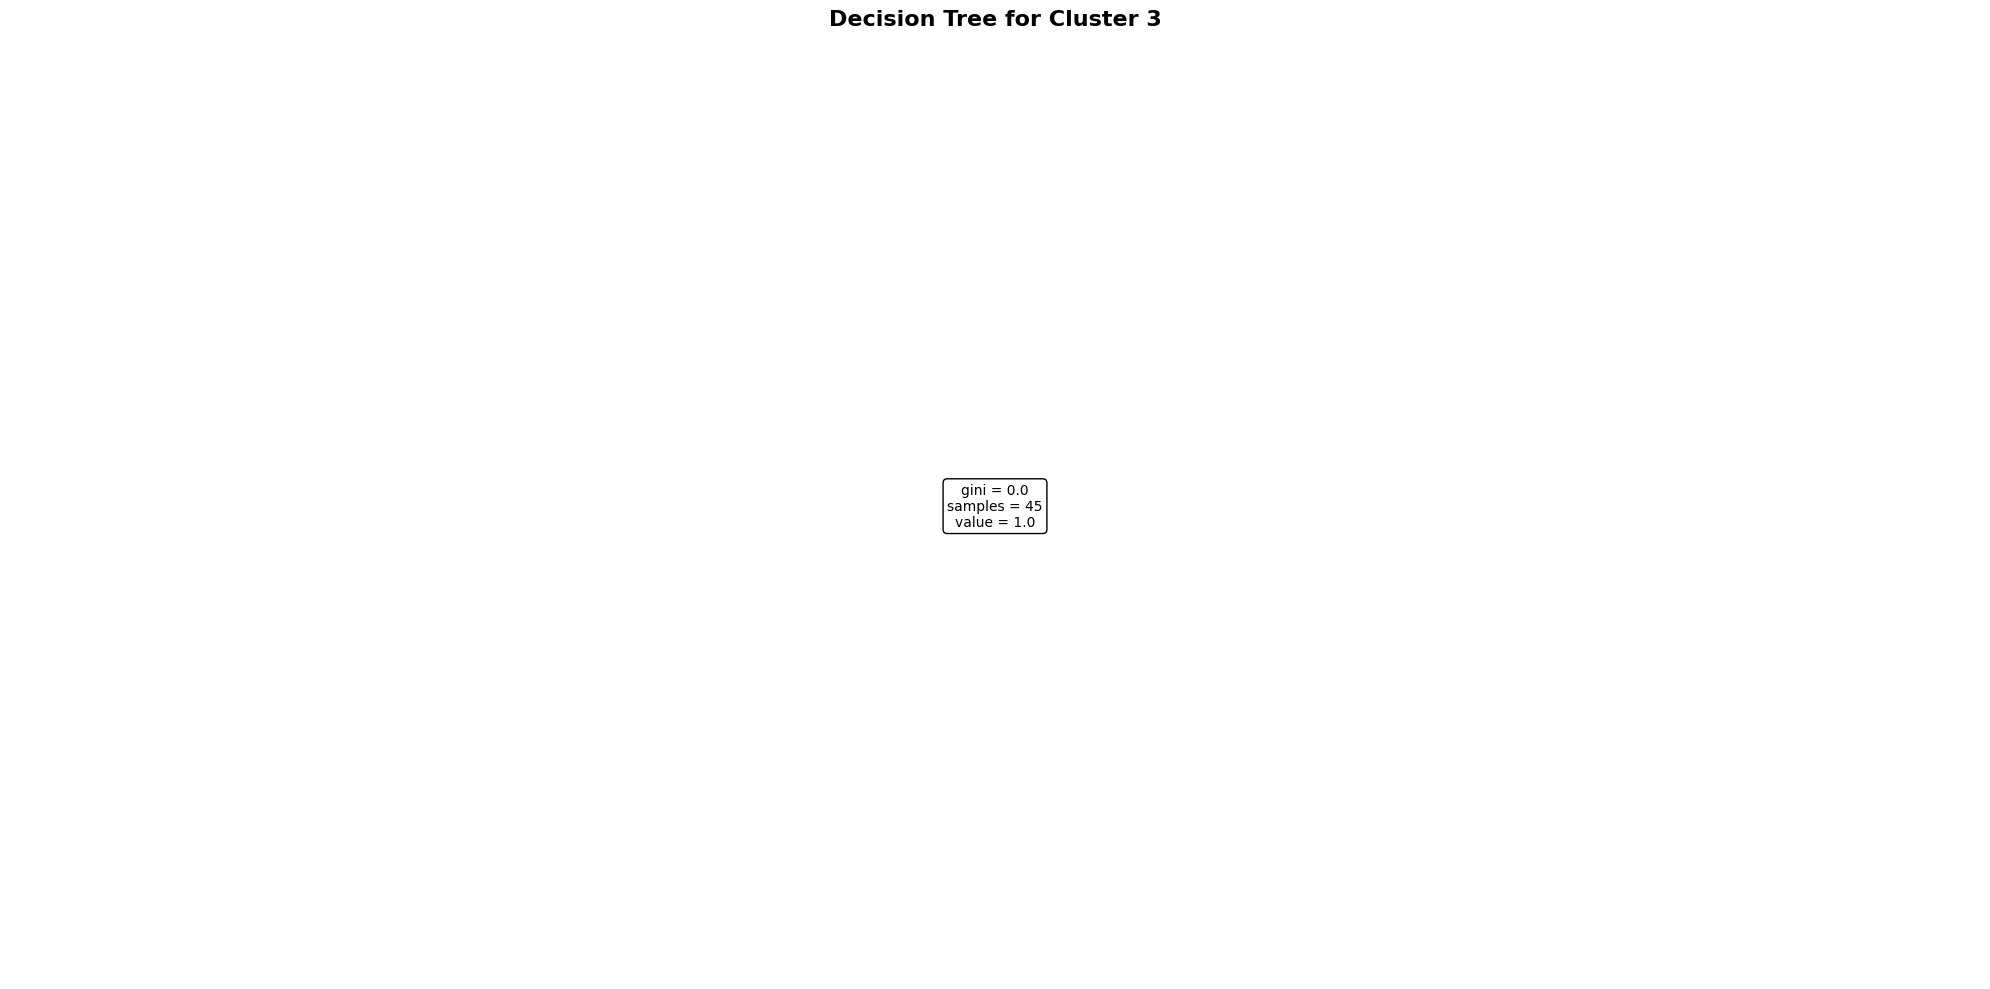


🔍 Sample Path Analysis:
──────────────────────────────────────────────────────────────────────
Random sample from cluster (index 262213):
  True Label: 0
  Predicted Label: 1
  Leaf Node: 0
  Leaf Class: 0
  Samples in Leaf: 1

  Path through tree:

  Full Path:  → Class 0



CLUSTER 4 - DECISION TREE VISUALIZATION

📊 Decision Tree Structure (Text Format):
──────────────────────────────────────────────────────────────────────
|--- class: 0


📈 Decision Tree Visualization:


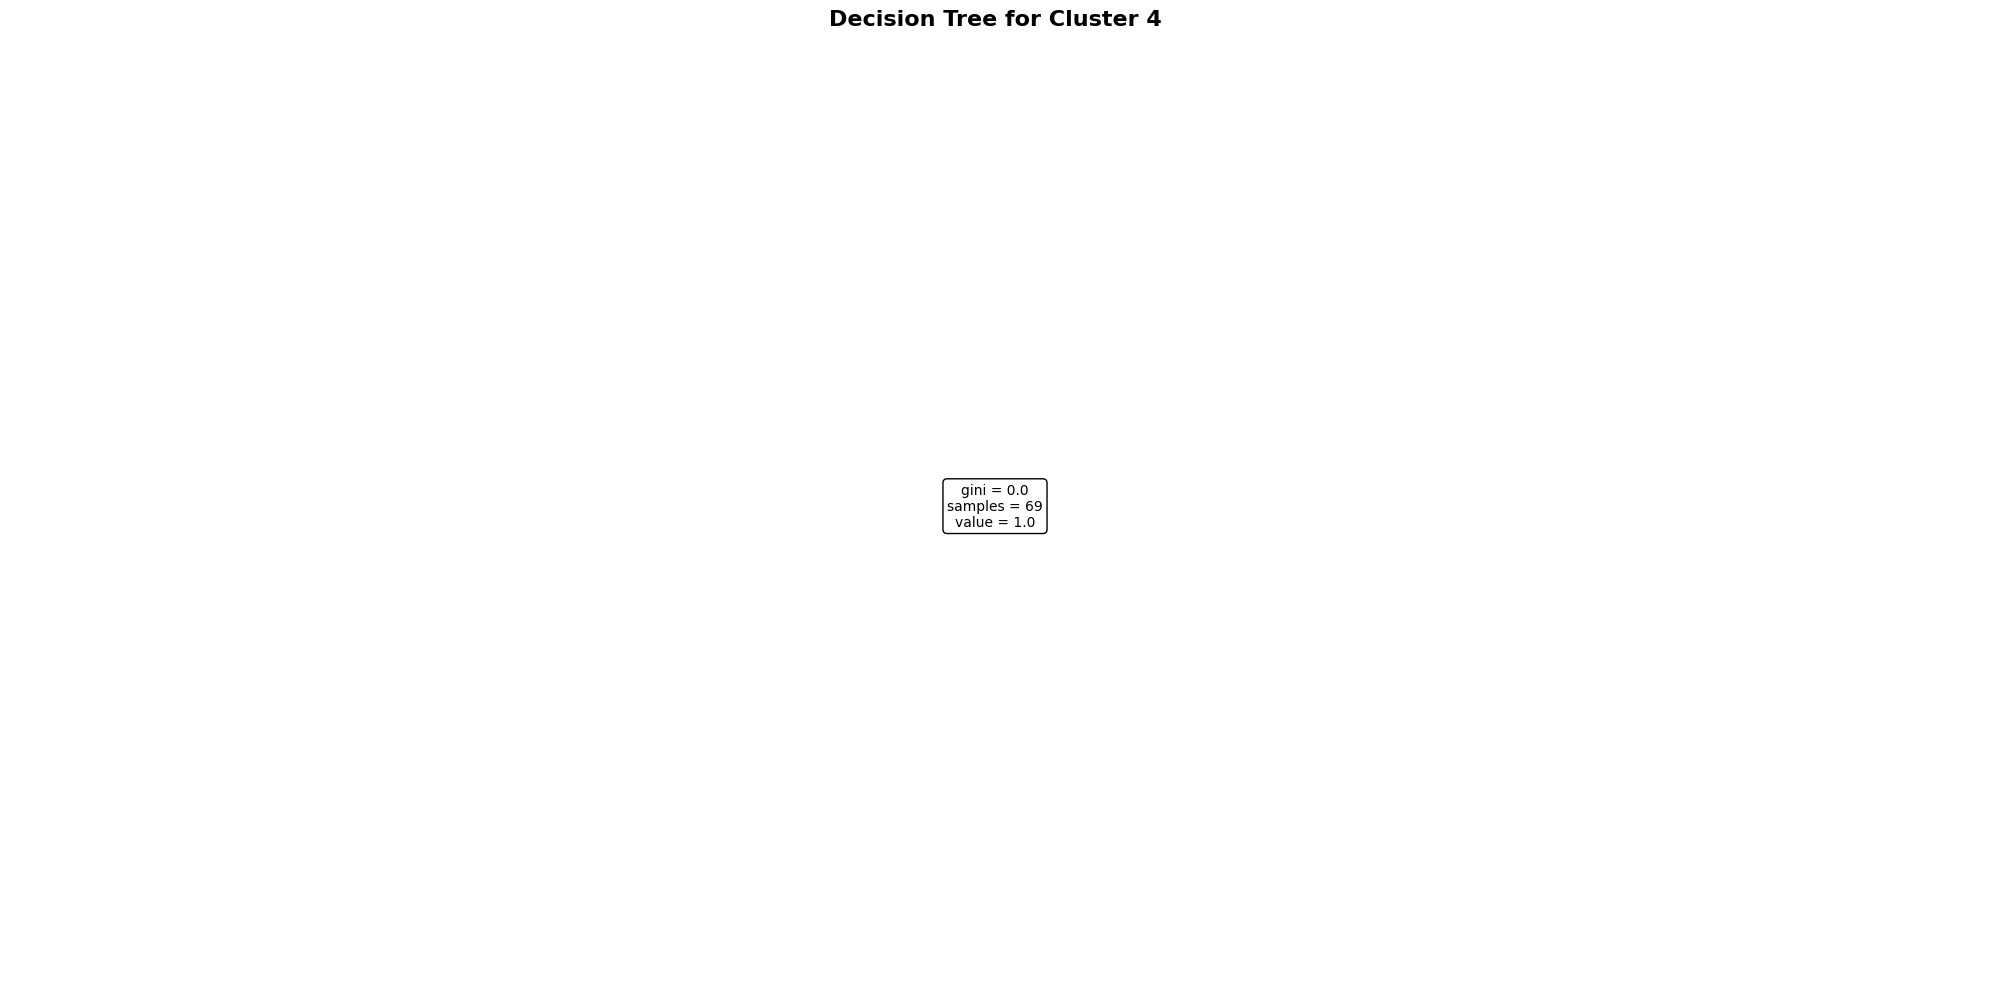


🔍 Sample Path Analysis:
──────────────────────────────────────────────────────────────────────
Random sample from cluster (index 40444):
  True Label: 0
  Predicted Label: 1
  Leaf Node: 0
  Leaf Class: 0
  Samples in Leaf: 1

  Path through tree:

  Full Path:  → Class 0



CLUSTER 5 - DECISION TREE VISUALIZATION

📊 Decision Tree Structure (Text Format):
──────────────────────────────────────────────────────────────────────
|--- initially_payable_to_institution <= 0.50
|   |--- loan_purpose <= 0.50
|   |   |--- class: 1
|   |--- loan_purpose >  0.50
|   |   |--- class: 1
|--- initially_payable_to_institution >  0.50
|   |--- class: 0


📈 Decision Tree Visualization:


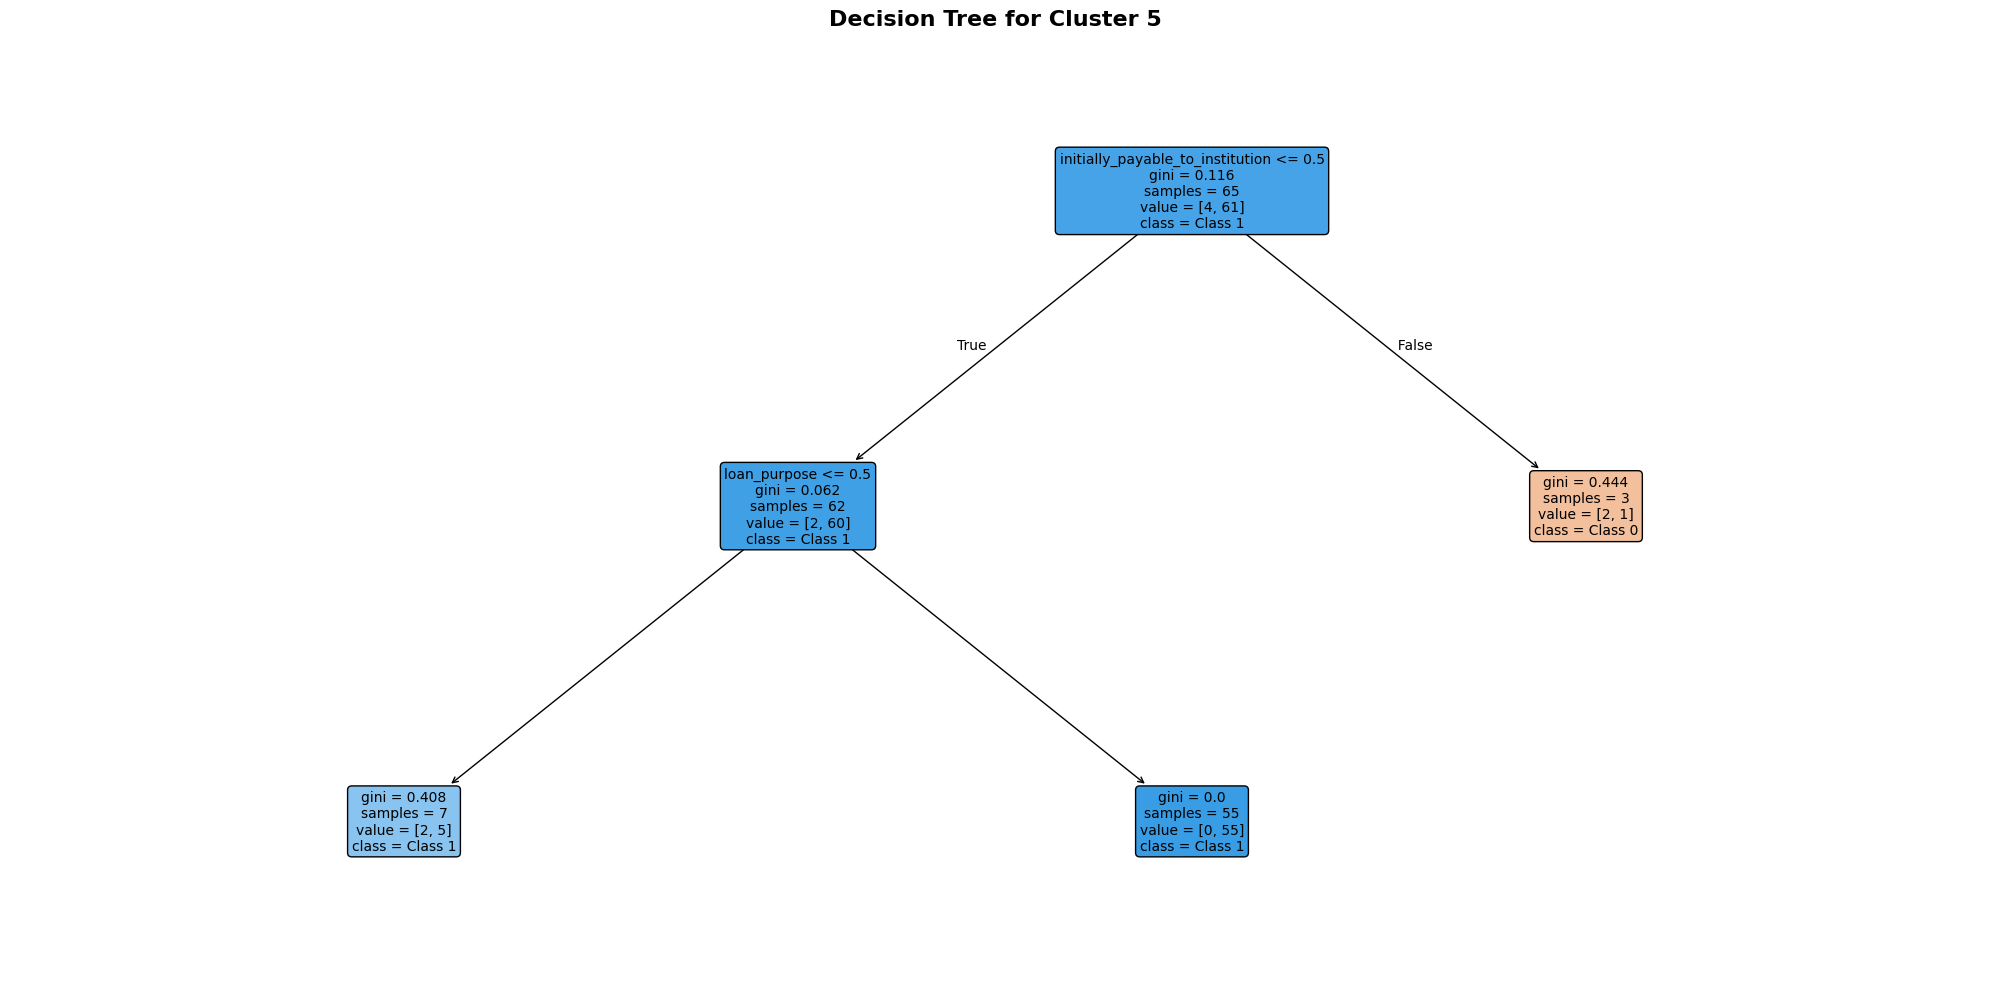


🔍 Sample Path Analysis:
──────────────────────────────────────────────────────────────────────
Random sample from cluster (index 276953):
  True Label: 1
  Predicted Label: 1
  Leaf Node: 3
  Leaf Class: 1
  Samples in Leaf: 1

  Path through tree:
    1. initially_payable_to_institution <= 0.5000 (value: 0.0000)
    2. loan_purpose > 0.5000 (value: 2.0000)

  Full Path: initially_payable_to_institution <= 0.5000 → loan_purpose > 0.5000 → Class 1




In [ ]:
# Visualize Decision Trees and Sample Paths for Each Cluster

def visualize_cluster_trees(local_rules, rule_extractor, X_train, y_train, feature_names):
    """Visualize decision trees and sample paths for each cluster."""
    
    if 'local_rules' not in globals():
        print("No local rules to visualize.")
        return
    
    for cluster_id, cluster_info in local_rules['clusters'].items():
        if cluster_info['n_samples'] < 5:  # Skip very small clusters
            continue
        
        if cluster_info.get('tree') is None:
            print(f"\n⚠️  Cluster {cluster_id}: No decision tree available")
            continue
        
        tree = cluster_info['tree']
        
        print(f"\n{'='*70}")
        print(f"CLUSTER {cluster_id} - DECISION TREE VISUALIZATION")
        print(f"{'='*70}")
        
        # Print tree in text format
        print(f"\n📊 Decision Tree Structure (Text Format):")
        print(f"{'─'*70}")
        rule_extractor.print_tree_text(tree, feature_names, max_depth=5)
        
        # Visualize tree
        print(f"\n📈 Decision Tree Visualization:")
        fig = rule_extractor.visualize_decision_tree(tree, cluster_id, feature_names, max_depth=5)
        plt.show()
        
        # Show path for a random sample from the cluster
        cluster_indices = cluster_info.get('cluster_indices', [])
        if len(cluster_indices) > 0:
            import random
            random_idx = random.choice(cluster_indices)
            sample = X_train[random_idx]
            sample_label = y_train[random_idx]
            
            print(f"\n🔍 Sample Path Analysis:")
            print(f"{'─'*70}")
            print(f"Random sample from cluster (index {random_idx}):")
            
            path_info = rule_extractor.visualize_sample_path(
                tree, sample, sample_label, cluster_id, feature_names
            )
            
            print(f"  True Label: {path_info['true_label']}")
            print(f"  Predicted Label: {path_info['predicted_label']}")
            print(f"  Leaf Node: {path_info['leaf_node']}")
            print(f"  Leaf Class: {path_info['leaf_class']}")
            print(f"  Samples in Leaf: {path_info['leaf_samples']}")
            print(f"\n  Path through tree:")
            for i, condition in enumerate(path_info['path_conditions'], 1):
                print(f"    {i}. {condition['condition']} (value: {condition['sample_value']:.4f})")
            print(f"\n  Full Path: {path_info['path_string']}")
        
        print(f"\n{'='*70}\n")

# Visualize trees if rules are available
if 'local_rules' in globals() and 'rule_extractor' in globals():
    visualize_cluster_trees(local_rules, rule_extractor, X_train, y_train, features)
else:
    print("No local rules or rule extractor found. Please run the rule extraction cells first.")


## Global Rule Aggregation from Local Rules

This section aggregates the local rules extracted from influence functions into global rules that explain the model's behavior across the entire dataset.

**Method**: Based on GLocalX algorithm:
1. **Partition**: Rules are grouped into conflicting, non-conflicting, and disjoint sets
2. **Cut**: Conflicting rules are resolved by keeping the dominant (highest fidelity) rule
3. **Join**: Non-conflicting rules with the same consequence are merged by intersecting shared features
4. **Accept**: Merges are accepted if they improve the BIC (Bayesian Information Criterion)

The result is a set of global rules that provide interpretable explanations of the model's decision-making process.

In [44]:
# Global Rule Aggregation from Local Rules
# This section aggregates local rules into global rules using GLocalX-style merging

# Setup Python path if needed
import os
import sys
if 'project_root' not in globals():
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(project_root)

from utilities.influence.global_rule_aggregation import (
    GlobalRuleAggregator, LocalRule, parse_rule_string,
    visualize_global_rules, print_global_rules,
    visualize_global_rules_as_tree, visualize_global_rules_hierarchy
)
import numpy as np
import pandas as pd

# ============================================================================
# STEP 1: Collect Local Rules from Multiple Test Samples
# ============================================================================

print("Collecting local rules for global aggregation...")
print("="*70)

local_rules_list = []

# Option 1: Use existing local_rules if available
if 'local_rules' in globals():
    local_rules_list.append(local_rules)
    print(f"✓ Added local rules from test sample {local_rules['test_id']}")
    print(f"  Clusters: {local_rules['n_clusters']}")

# Option 2: Extract rules for additional test samples (recommended for better global rules)
# Extract rules from multiple test samples to get diverse local rules
if 'rule_extractor' in globals() and 'X_train' in globals():
    csv_path = os.path.join(project_root, "training", "influences.csv")
    if os.path.exists(csv_path):
        print(f"\n📊 Loading test IDs from CSV: {csv_path}")
        
        # Get unique test IDs (sample first 50k rows for speed)
        df_sample = pd.read_csv(csv_path, nrows=50000, usecols=['test_id'])
        unique_test_ids = sorted(df_sample['test_id'].unique())
        
        # Determine how many test samples to use
        # If we already have one, extract a few more
        num_additional = 9  # Extract rules from 9 more test samples (10 total)
        test_ids_to_extract = unique_test_ids[:num_additional]
        
        # Skip if we already have rules for the first test_id
        if 'local_rules' in globals() and local_rules['test_id'] in test_ids_to_extract:
            test_ids_to_extract = [tid for tid in test_ids_to_extract if tid != local_rules['test_id']]
        
        print(f"  Found {len(unique_test_ids)} unique test IDs in sample")
        print(f"  Extracting rules from {len(test_ids_to_extract)} additional test samples...")
        
        extracted_count = 0
        for test_id in test_ids_to_extract:
            try:
                test_rules = rule_extractor.extract_local_rules_from_csv(
                    csv_path=csv_path,
                    test_id=test_id,
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test if 'X_test' in globals() else None,
                    top_k=50,
                    clustering_method='kmeans'
                )
                local_rules_list.append(test_rules)
                extracted_count += 1
                if extracted_count % 3 == 0:
                    print(f"    ✓ Extracted {extracted_count}/{len(test_ids_to_extract)}...")
            except Exception as e:
                print(f"    ⚠ Could not extract rules for test_id {test_id}: {str(e)[:50]}")
                continue
        
        print(f"  ✓ Successfully extracted rules from {extracted_count} additional test samples")
    else:
        print(f"  ⚠ CSV file not found at {csv_path}")

print(f"\n{'='*70}")
print(f"Total local rule sets collected: {len(local_rules_list)}")

# Count total rules across all sets
total_rules = sum(len(lr.get('clusters', {})) for lr in local_rules_list)
print(f"Total local rules (clusters) to aggregate: {total_rules}")

# ============================================================================
# STEP 2: Initialize Global Rule Aggregator
# ============================================================================

if len(local_rules_list) > 0 and 'features' in globals() and 'X_train' in globals():
    print(f"\n{'='*70}")
    print("INITIALIZING GLOBAL RULE AGGREGATOR")
    print(f"{'='*70}")
    print(f"Feature names: {len(features)} features")
    print(f"Training data: {len(X_train)} samples")
    
    global_aggregator = GlobalRuleAggregator(
        feature_names=features,
        fidelity_weight=1.0,      # Weight for fidelity in BIC
        complexity_weight=1.0,     # Weight for complexity in BIC
        strict_join=True,          # Only merge shared features
        strict_cut=True            # Cut on all features
    )
    
    print("\n" + "="*70)
    print("AGGREGATING LOCAL RULES INTO GLOBAL RULES")
    print("="*70)
    print("Algorithm: GLocalX-style merging (partition → cut → join)")
    print("This may take a few minutes depending on the number of rules...")
    print()
    
    # Aggregate rules
    global_rules = global_aggregator.aggregate(
        local_rules_list=local_rules_list,
        x=X_train,
        y=y_train,
        alpha=0.5,          # Minimum fidelity threshold (0-1)
        max_iterations=50   # Maximum merging iterations
    )
    
    print(f"\n{'='*70}")
    print(f"✓ AGGREGATION COMPLETE!")
    print(f"{'='*70}")
    print(f"Generated {len(global_rules)} global rules")
    if len(global_rules) > 0:
        avg_fidelity = np.mean([global_aggregator.binary_fidelity(r, X_train, y_train) 
                               for r in global_rules[:10]])
        print(f"Average fidelity (top 10): {avg_fidelity:.4f}")
    
else:
    print("\n" + "="*70)
    print("⚠️  CANNOT PROCEED")
    print("="*70)
    missing = []
    if len(local_rules_list) == 0:
        missing.append("local_rules_list (no local rules collected)")
    if 'features' not in globals():
        missing.append("features")
    if 'X_train' not in globals():
        missing.append("X_train")
    print(f"Missing: {', '.join(missing)}")
    print("\nPlease ensure:")
    print("  1. Run the local rule extraction section first")
    print("  2. Variables 'features', 'X_train', 'y_train' are available")
    
    global_aggregator = None
    global_rules = []


📊 Loading test IDs from CSV: /Users/juliettegarcia/Documents/localToGlobalExpProject/TrustWorthyXAILocaltoGlobal/training/influences.csv
  Found 49 unique test IDs in sample
  Extracting rules from 9 additional test samples...
    ✓ Extracted 3/9...
    ✓ Extracted 6/9...
    ✓ Extracted 9/9...
  ✓ Successfully extracted rules from 9 additional test samples

Total local rule sets collected: 9
Total local rules (clusters) to aggregate: 54

INITIALIZING GLOBAL RULE AGGREGATOR
Feature names: 19 features
Training data: 281900 samples

AGGREGATING LOCAL RULES INTO GLOBAL RULES
Algorithm: GLocalX-style merging (partition → cut → join)
This may take a few minutes depending on the number of rules...


✓ AGGREGATION COMPLETE!
Generated 4 global rules
Average fidelity (top 10): 0.7122


In [45]:
# Visualize Cluster Structure and Rule Coverage

def visualize_rule_clusters(local_rules, X_train, feature_names, top_features=5):
    """Visualize how clusters relate to features and influences."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if 'local_rules' not in globals():
        print("No local rules to visualize.")
        return
    
    # Get cluster data
    cluster_labels = np.array(local_rules['cluster_data']['cluster_labels'])
    influence_signs = np.array(local_rules['cluster_data']['influence_signs'])
    
    # Get features for influential samples
    all_indices = local_rules['helpful_samples'] + local_rules['harmful_samples']
    influential_features = X_train[all_indices]
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Cluster distribution by influence sign
    unique_clusters = np.unique(cluster_labels)
    cluster_influence_counts = []
    cluster_labels_list = []
    influence_type = []
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # Skip noise
            continue
        mask = cluster_labels == cluster_id
        helpful_count = (influence_signs[mask] > 0).sum()
        harmful_count = (influence_signs[mask] < 0).sum()
        
        cluster_influence_counts.extend([helpful_count, harmful_count])
        cluster_labels_list.extend([f'Cluster {cluster_id}', f'Cluster {cluster_id}'])
        influence_type.extend(['Helpful', 'Harmful'])
    
    if cluster_influence_counts:
        df_cluster = pd.DataFrame({
            'Cluster': cluster_labels_list,
            'Count': cluster_influence_counts,
            'Type': influence_type
        })
        sns.barplot(data=df_cluster, x='Cluster', y='Count', hue='Type', ax=axes[0, 0])
        axes[0, 0].set_title('Cluster Distribution by Influence Type')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Feature importance across clusters (using variance)
    feature_variance = np.var(influential_features, axis=0)
    top_feature_indices = np.argsort(feature_variance)[-top_features:][::-1]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    
    axes[0, 1].barh(range(len(top_feature_names)), feature_variance[top_feature_indices])
    axes[0, 1].set_yticks(range(len(top_feature_names)))
    axes[0, 1].set_yticklabels(top_feature_names)
    axes[0, 1].set_xlabel('Feature Variance')
    axes[0, 1].set_title(f'Top {top_features} Most Variable Features in Influential Samples')
    axes[0, 1].invert_yaxis()
    
    # 3. Cluster separation (2D projection using PCA on top features)
    from sklearn.decomposition import PCA
    
    if len(influential_features) > 1:
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(influential_features[:, top_feature_indices])
        
        scatter = axes[1, 0].scatter(features_2d[:, 0], features_2d[:, 1], 
                                    c=cluster_labels, cmap='tab10', 
                                    alpha=0.6, s=50)
        axes[1, 0].set_xlabel(f'PC1 (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
        axes[1, 0].set_ylabel(f'PC2 (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
        axes[1, 0].set_title('Cluster Visualization (2D Projection)')
        axes[1, 0].legend(*scatter.legend_elements(), title="Clusters")
        plt.colorbar(scatter, ax=axes[1, 0])
    
    # 4. Rule coverage: Show which clusters have valid rules
    cluster_ids = []
    has_explanation = []
    has_counterfactual = []
    n_samples_list = []
    
    for cluster_id, cluster_info in local_rules['clusters'].items():
        cluster_ids.append(f'Cluster {cluster_id}')
        has_explanation.append(1 if cluster_info['explanation_rule'] else 0)
        has_counterfactual.append(1 if cluster_info['counterfactual_rule'] else 0)
        n_samples_list.append(cluster_info['n_samples'])
    
    if cluster_ids:
        x = np.arange(len(cluster_ids))
        width = 0.35
        axes[1, 1].bar(x - width/2, has_explanation, width, label='Has Explanation Rule', color='lightblue')
        axes[1, 1].bar(x + width/2, has_counterfactual, width, label='Has Counterfactual Rule', color='lightcoral')
        axes[1, 1].set_xlabel('Cluster')
        axes[1, 1].set_ylabel('Rule Availability')
        axes[1, 1].set_title('Rule Coverage by Cluster')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(cluster_ids, rotation=45, ha='right')
        axes[1, 1].legend()
        axes[1, 1].set_ylim([0, 1.2])
        
        # Add sample counts as text
        for i, n_samples in enumerate(n_samples_list):
            axes[1, 1].text(i, 1.1, f'n={n_samples}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary:")
    print(f"  Total clusters: {local_rules['n_clusters']}")
    print(f"  Clusters with explanation rules: {sum(1 for c in local_rules['clusters'].values() if c['explanation_rule'])}")
    print(f"  Clusters with counterfactual rules: {sum(1 for c in local_rules['clusters'].values() if c['counterfactual_rule'])}")

# Visualize if rules are available
if 'local_rules' in globals():
    visualize_rule_clusters(local_rules, X_train, features, top_features=10)
else:
    print("No local rules to visualize. Please run the rule extraction cell first.")


No local rules to visualize. Please run the rule extraction cell first.



GLOBAL RULES - TEXT FORMAT

GLOBAL RULES (Top 4 of 4)

Rule 1:
  IF derived_msa_md <= 55.5000 THEN class = 1
  Fidelity: 0.7575
  Coverage: 37250 samples (13.21%)
  Features: 1

Rule 2:
  IF derived_msa_md > 389.0000 THEN class = 1
  Fidelity: 0.7575
  Coverage: 50877 samples (18.05%)
  Features: 1

Rule 3:
  IF derived_msa_md <= 212.1200 AND state_code <= 31.5200 THEN class = 0
  Fidelity: 0.7096
  Coverage: 37250 samples (13.21%)
  Features: 2

Rule 4:
  IF derived_msa_md <= 261.5238 AND state_code <= 36.0952 AND loan_purpose <= 0.2857 THEN class = 0
  Fidelity: 0.6242
  Coverage: 50257 samples (17.83%)
  Features: 3


GLOBAL RULES VISUALIZATION
Generating visualizations...


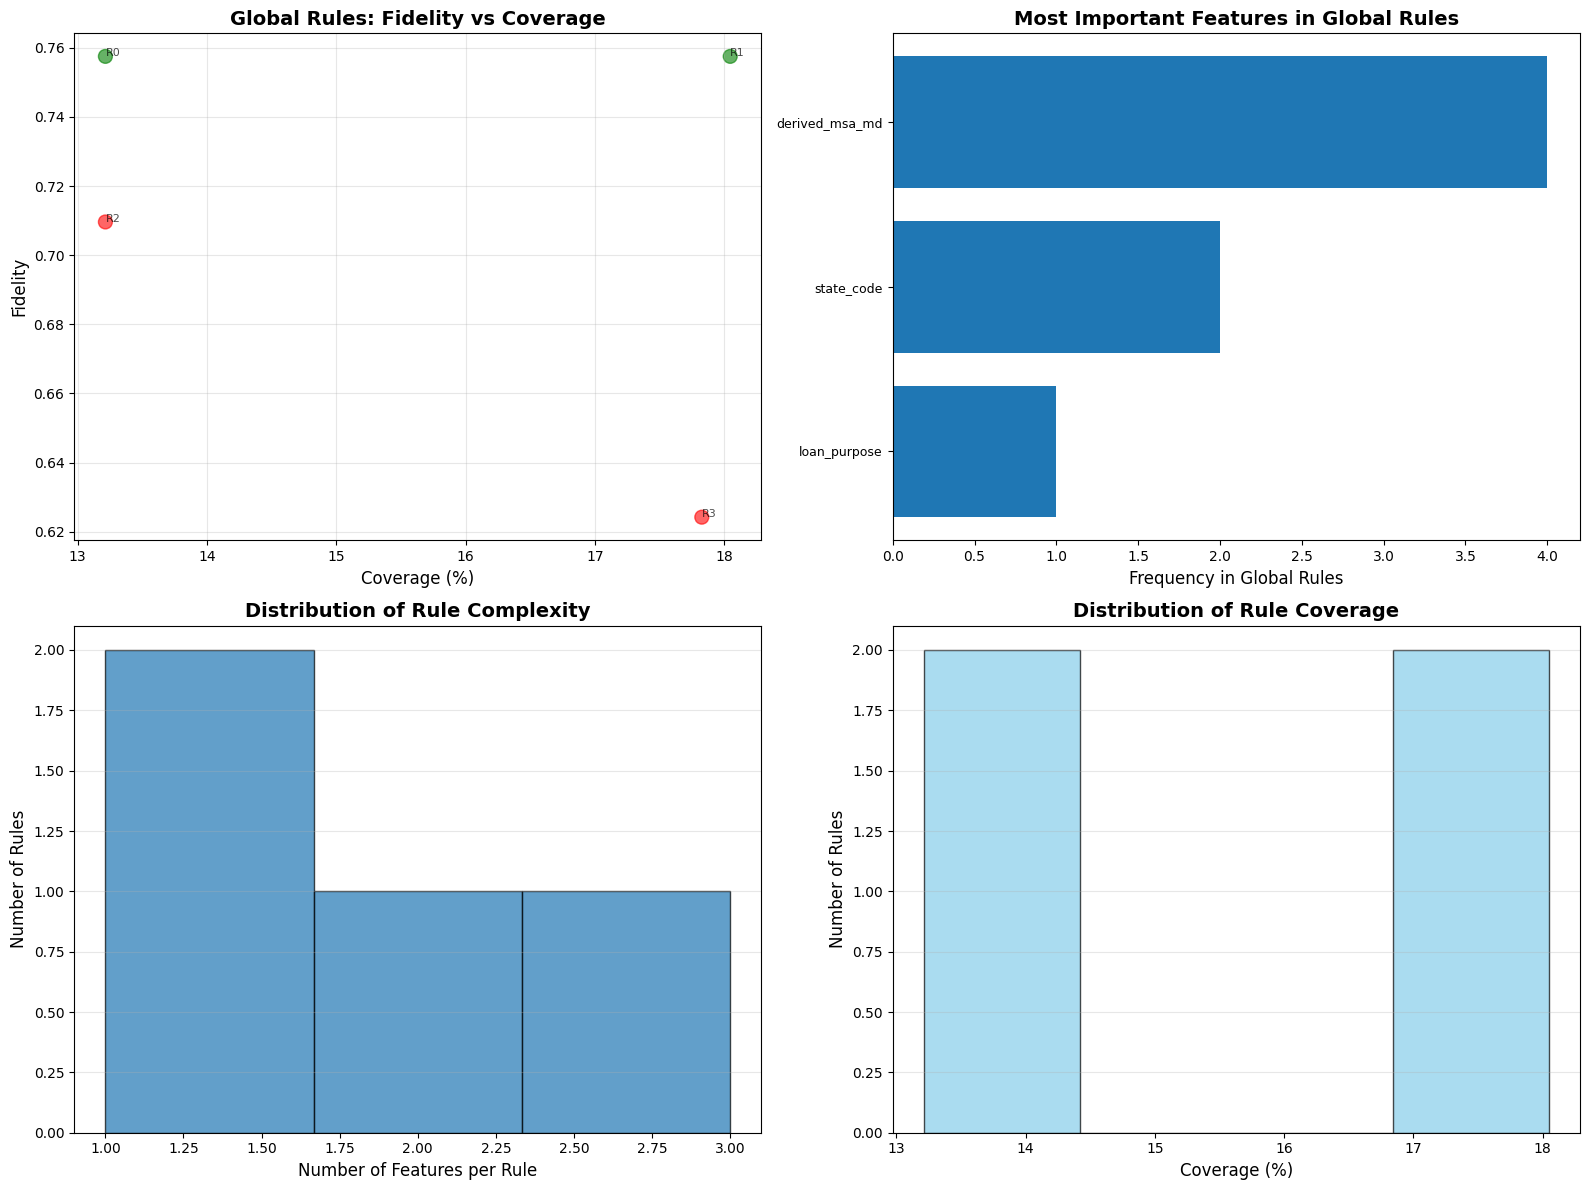


GLOBAL RULES SUMMARY STATISTICS
Total global rules generated: 4

📊 Quality Metrics (Top 4 Rules):
  Average fidelity: 0.7122 (std: 0.0544)
  Average coverage: 15.58% (std: 2.36%)
  Average complexity: 1.8 features/rule (std: 0.8)
  Min fidelity: 0.6242
  Max fidelity: 0.7575

📈 Class Distribution:
  Class 0 (Reject) rules: 2 (50.0%)
  Class 1 (Approve) rules: 2 (50.0%)

📉 Coverage Analysis:
  Total samples covered (sum): 175,634
  Unique samples covered: 129,716 (46.01%)
  Overlap: 45,918 samples covered by multiple rules

✓ Global rule visualization complete!


In [46]:
# Display and Visualize Global Rules

if 'global_rules' in globals() and len(global_rules) > 0 and 'global_aggregator' in globals():
    print("\n" + "="*80)
    print("GLOBAL RULES - TEXT FORMAT")
    print("="*80)
    
    # Print global rules in human-readable format
    print_global_rules(global_rules, global_aggregator, X_train, y_train, top_k=15)
    
    # Visualize global rules
    print("\n" + "="*80)
    print("GLOBAL RULES VISUALIZATION")
    print("="*80)
    print("Generating visualizations...")
    
    try:
        fig, rule_metrics = visualize_global_rules(
            global_rules=global_rules,
            aggregator=global_aggregator,
            x=X_train,
            y=y_train,
            feature_names=features,
            top_k=min(15, len(global_rules))
        )
        
        plt.show()
        
        # Summary statistics
        print("\n" + "="*80)
        print("GLOBAL RULES SUMMARY STATISTICS")
        print("="*80)
        print(f"Total global rules generated: {len(global_rules)}")
        
        if len(rule_metrics) > 0:
            fidelities = [m['fidelity'] for m in rule_metrics]
            coverages = [m['coverage_pct'] for m in rule_metrics]
            complexities = [m['n_features'] for m in rule_metrics]
            
            print(f"\n📊 Quality Metrics (Top {len(rule_metrics)} Rules):")
            print(f"  Average fidelity: {np.mean(fidelities):.4f} (std: {np.std(fidelities):.4f})")
            print(f"  Average coverage: {np.mean(coverages):.2f}% (std: {np.std(coverages):.2f}%)")
            print(f"  Average complexity: {np.mean(complexities):.1f} features/rule (std: {np.std(complexities):.1f})")
            print(f"  Min fidelity: {np.min(fidelities):.4f}")
            print(f"  Max fidelity: {np.max(fidelities):.4f}")
            
            # Class distribution
            class_0_rules = sum(1 for m in rule_metrics if m['consequence'] == 0)
            class_1_rules = sum(1 for m in rule_metrics if m['consequence'] == 1)
            print(f"\n📈 Class Distribution:")
            print(f"  Class 0 (Reject) rules: {class_0_rules} ({100*class_0_rules/len(rule_metrics):.1f}%)")
            print(f"  Class 1 (Approve) rules: {class_1_rules} ({100*class_1_rules/len(rule_metrics):.1f}%)")
            
            # Coverage analysis
            total_coverage = sum(m['coverage'] for m in rule_metrics)
            # Calculate unique coverage (samples covered by at least one rule)
            all_covered_indices = set()
            for m in rule_metrics:
                rule_idx = m['rule_id']
                if rule_idx < len(global_rules):
                    coverage_mask = global_aggregator.coverage(global_rules[rule_idx], X_train)
                    covered_indices = set(np.where(coverage_mask)[0])
                    all_covered_indices.update(covered_indices)
            unique_coverage = len(all_covered_indices)
            print(f"\n📉 Coverage Analysis:")
            print(f"  Total samples covered (sum): {total_coverage:,}")
            print(f"  Unique samples covered: {unique_coverage:,} ({100*unique_coverage/len(X_train):.2f}%)")
            print(f"  Overlap: {total_coverage - unique_coverage:,} samples covered by multiple rules")
        
        print(f"\n{'='*80}")
        print("✓ Global rule visualization complete!")
        print(f"{'='*80}")
        
    except Exception as e:
        print(f"⚠️  Error during visualization: {e}")
        import traceback
        traceback.print_exc()
    
else:
    print("="*80)
    print("⚠️  NO GLOBAL RULES AVAILABLE")
    print("="*80)
    if 'global_rules' not in globals():
        print("  - 'global_rules' variable not found")
    elif len(global_rules) == 0:
        print("  - 'global_rules' is empty (no rules were generated)")
    if 'global_aggregator' not in globals():
        print("  - 'global_aggregator' not found")
    print("\nPlease run the global rule aggregation cell (Cell 61) first.")



GLOBAL RULES - TREE VISUALIZATION
Visualizing existing global rules directly (no re-training)...

📊 Creating tree visualization from global rules...

Global Rules Tree Visualization
Total rules visualized: 4
Each path represents one global rule
Leaf nodes show: Class prediction, Coverage %, Fidelity



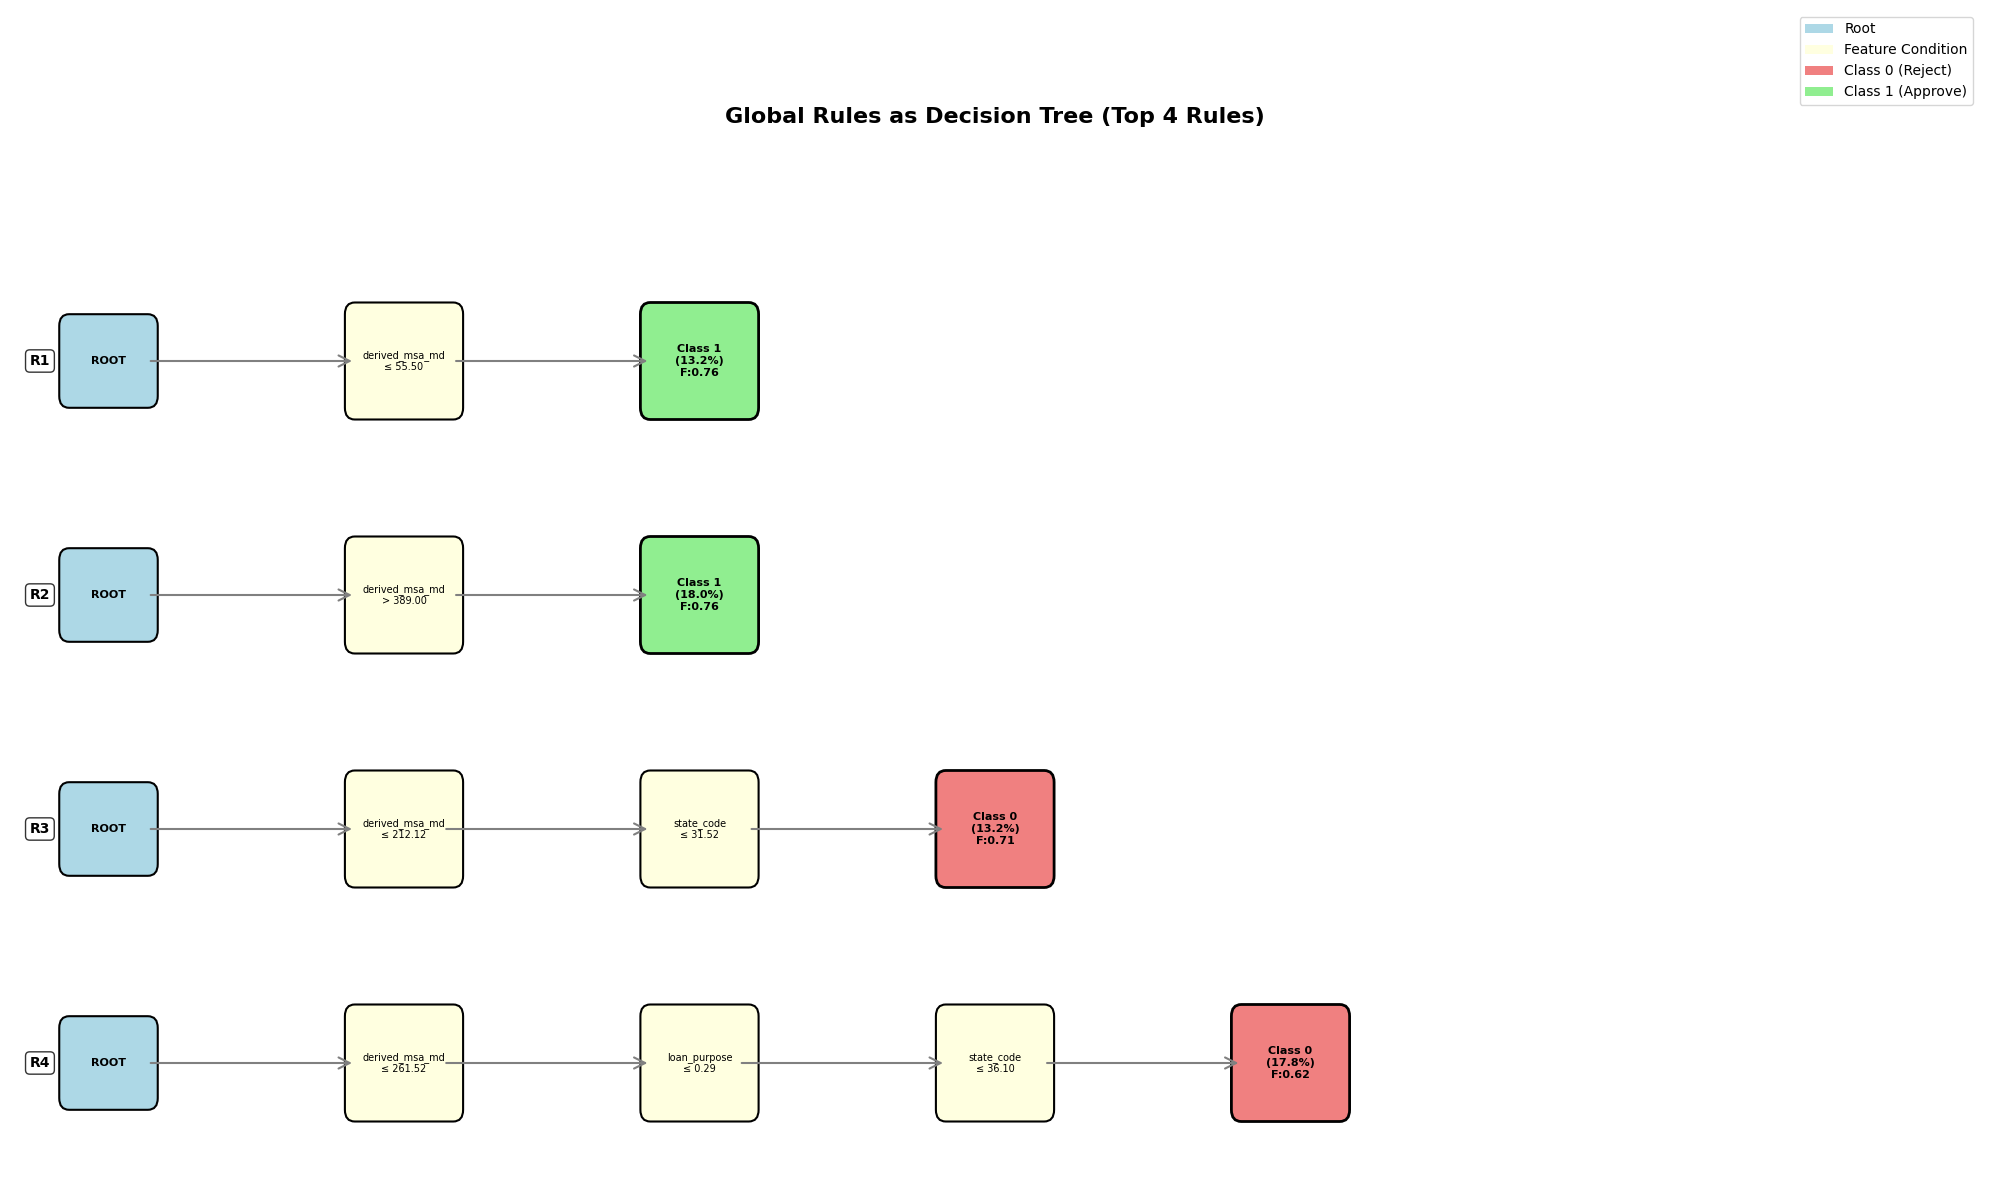


📊 Creating hierarchical network visualization...

Rule Relationships:
  Total rules: 4
  Total edges (overlaps): 6
  Average features per rule: 1.8


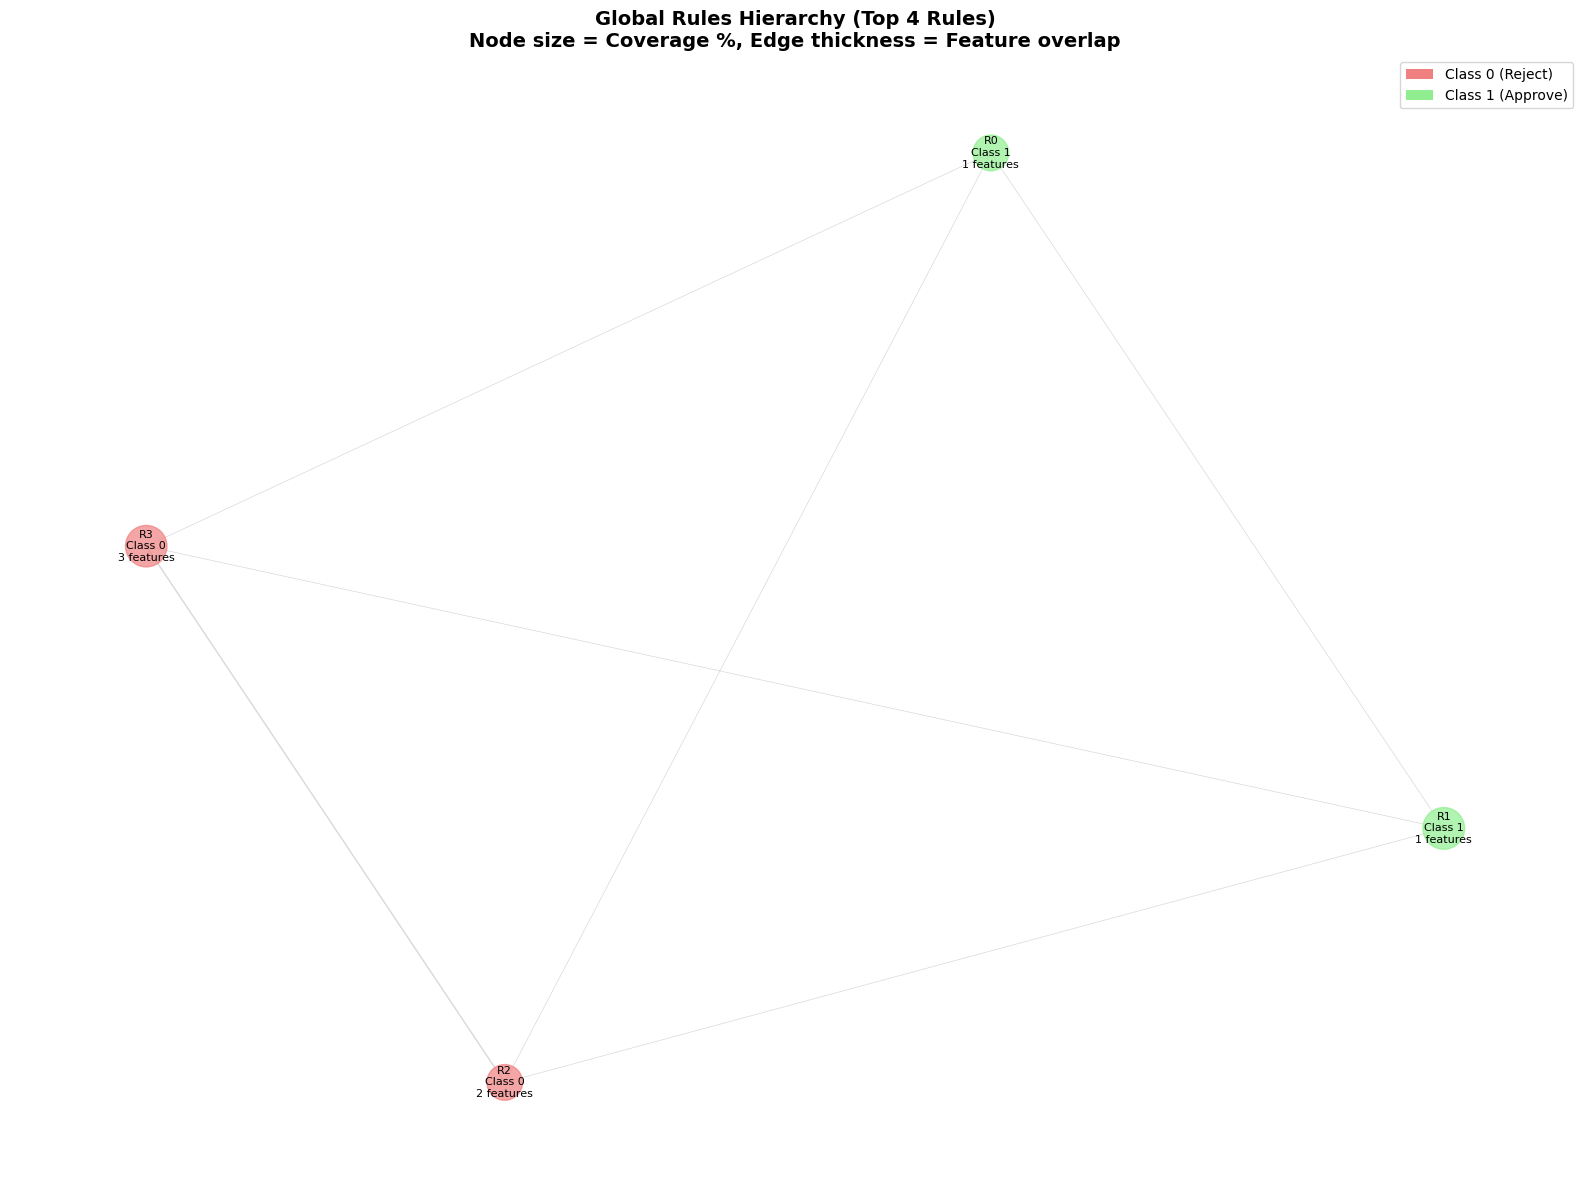


DETAILED RULE INFORMATION

Rule 1:
  IF derived_msa_md <= 55.5000 THEN class = 1
  Coverage: 37,250 samples (13.21%)
  Fidelity: 0.7575
  Features: 1 (derived_msa_md)

Rule 2:
  IF derived_msa_md > 389.0000 THEN class = 1
  Coverage: 50,877 samples (18.05%)
  Fidelity: 0.7575
  Features: 1 (derived_msa_md)

Rule 3:
  IF derived_msa_md <= 212.1200 AND state_code <= 31.5200 THEN class = 0
  Coverage: 37,250 samples (13.21%)
  Fidelity: 0.7096
  Features: 2 (derived_msa_md, state_code)

Rule 4:
  IF derived_msa_md <= 261.5238 AND state_code <= 36.0952 AND loan_purpose <= 0.2857 THEN class = 0
  Coverage: 50,257 samples (17.83%)
  Fidelity: 0.6242
  Features: 3 (derived_msa_md, loan_purpose, state_code)

✓ Tree visualizations complete!


In [47]:
# Visualize Global Rules as Decision Trees
# This visualization directly shows the global rules as tree paths
# WITHOUT re-training or re-aggregating

from utilities.influence.global_rule_aggregation import (
    visualize_global_rules_as_tree, visualize_global_rules_hierarchy
)
import matplotlib.pyplot as plt

if 'global_rules' in globals() and len(global_rules) > 0 and 'global_aggregator' in globals():
    print("\n" + "="*80)
    print("GLOBAL RULES - TREE VISUALIZATION")
    print("="*80)
    print("Visualizing existing global rules directly (no re-training)...")
    
    # ============================================================================
    # Visualization 1: Direct Tree Visualization of Global Rules
    # Each rule is shown as a path from root to leaf
    # ============================================================================
    print("\n📊 Creating tree visualization from global rules...")
    
    fig_tree, rule_paths = visualize_global_rules_as_tree(
        global_rules=global_rules,
        aggregator=global_aggregator,
        x=X_train,
        y=y_train,
        feature_names=features,
        top_k=min(15, len(global_rules)),
        max_depth=6
    )
    
    if fig_tree is not None:
        plt.show()
    
    # ============================================================================
    # Visualization 2: Hierarchical Network of Global Rules
    # Shows relationships between rules through feature overlaps
    # ============================================================================
    print("\n📊 Creating hierarchical network visualization...")
    
    try:
        import networkx as nx
        fig_hierarchy, rule_graph = visualize_global_rules_hierarchy(
            global_rules=global_rules,
            aggregator=global_aggregator,
            x=X_train,
            y=y_train,
            feature_names=features,
            top_k=min(15, len(global_rules))
        )
        
        if fig_hierarchy is not None:
            plt.show()
    except ImportError:
        print("⚠️  networkx not available. Skipping hierarchy visualization.")
        print("    Install with: pip install networkx")
    except Exception as e:
        print(f"⚠️  Error creating hierarchy: {e}")
    
    # ============================================================================
    # Print Rule Details
    # ============================================================================
    print("\n" + "="*80)
    print("DETAILED RULE INFORMATION")
    print("="*80)
    
    for idx, rule in enumerate(global_rules[:10]):
        coverage = global_aggregator.coverage(rule, X_train)
        fidelity = global_aggregator.binary_fidelity(rule, X_train, y_train)
        coverage_pct = (coverage.sum() / len(X_train)) * 100
        
        print(f"\nRule {idx+1}:")
        print(f"  {str(rule)}")
        print(f"  Coverage: {coverage.sum():,} samples ({coverage_pct:.2f}%)")
        print(f"  Fidelity: {fidelity:.4f}")
        print(f"  Features: {len(rule.features)} ({', '.join(sorted(list(rule.features)[:5]))}{'...' if len(rule.features) > 5 else ''})")
    
    print("\n" + "="*80)
    print("✓ Tree visualizations complete!")
    print("="*80)
    
else:
    print("⚠️  No global rules available. Please run the aggregation cell first.")


## Surrogate Tree Evaluation: Three-Way Comparison

This section evaluates three different surrogate tree approaches:
1. **Influence-Based Global Rules Surrogate**: A tree built from aggregated local rules extracted via influence functions
2. **LORE->GLocalX Surrogate**: A tree built from LORE local rules aggregated using GLocalX
3. **Baseline Decision Tree**: A standard decision tree trained directly on TabNet's predictions

We measure:
1. Prediction accuracy on test data
2. Fidelity to TabNet predictions
3. Rule complexity and interpretability
4. Coverage of the dataset


SURROGATE TREE EVALUATION - THREE-WAY COMPARISON

This section compares:
  1. Influence-Based Global Rules Surrogate (from influence-based local rules)
  2. LORE->GLocalX Surrogate (from LORE local rules aggregated via GLocalX)
  3. Baseline Decision Tree (trained directly on TabNet predictions)

✓ All prerequisites met!
  - Global rules: 4 rules
  - Test set size: 35,474 samples
  - Number of features: 19

STEP 1: Creating Global Rules Surrogate Predictor

Global Rules Surrogate Tree:
  Total rules: 4
  Test samples covered: 0 / 35,474 (0.00%)
  Uncovered samples (using default): 35,474

STEP 2: Creating LORE->GLocalX Surrogate Tree

⚠️  LORE not available: No module named 'deap'
   Skipping LORE->GLocalX surrogate tree
   Install LORE dependencies or ensure LORE_sa-main is in utilities/

STEP 3: Creating Baseline Decision Tree from TabNet Predictions

Generating TabNet predictions on training data...
  TabNet training predictions shape: (281900,)
  TabNet training accuracy: 0.7058

T

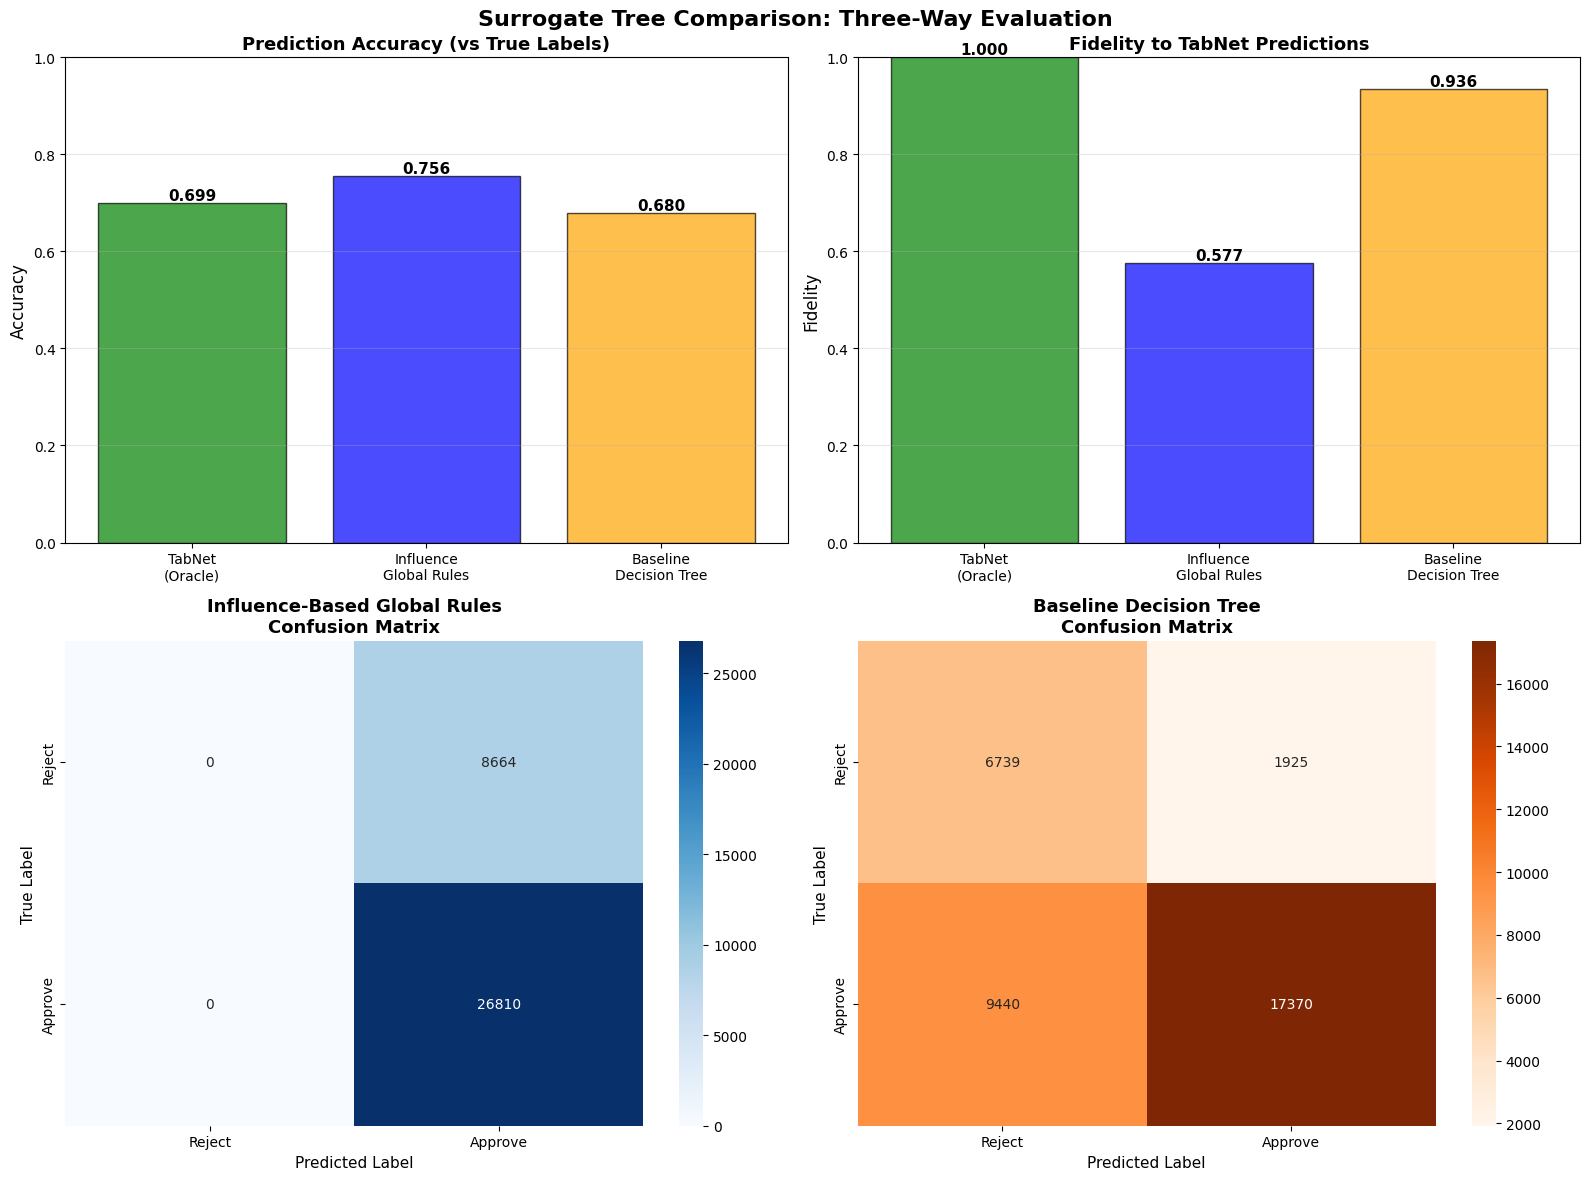

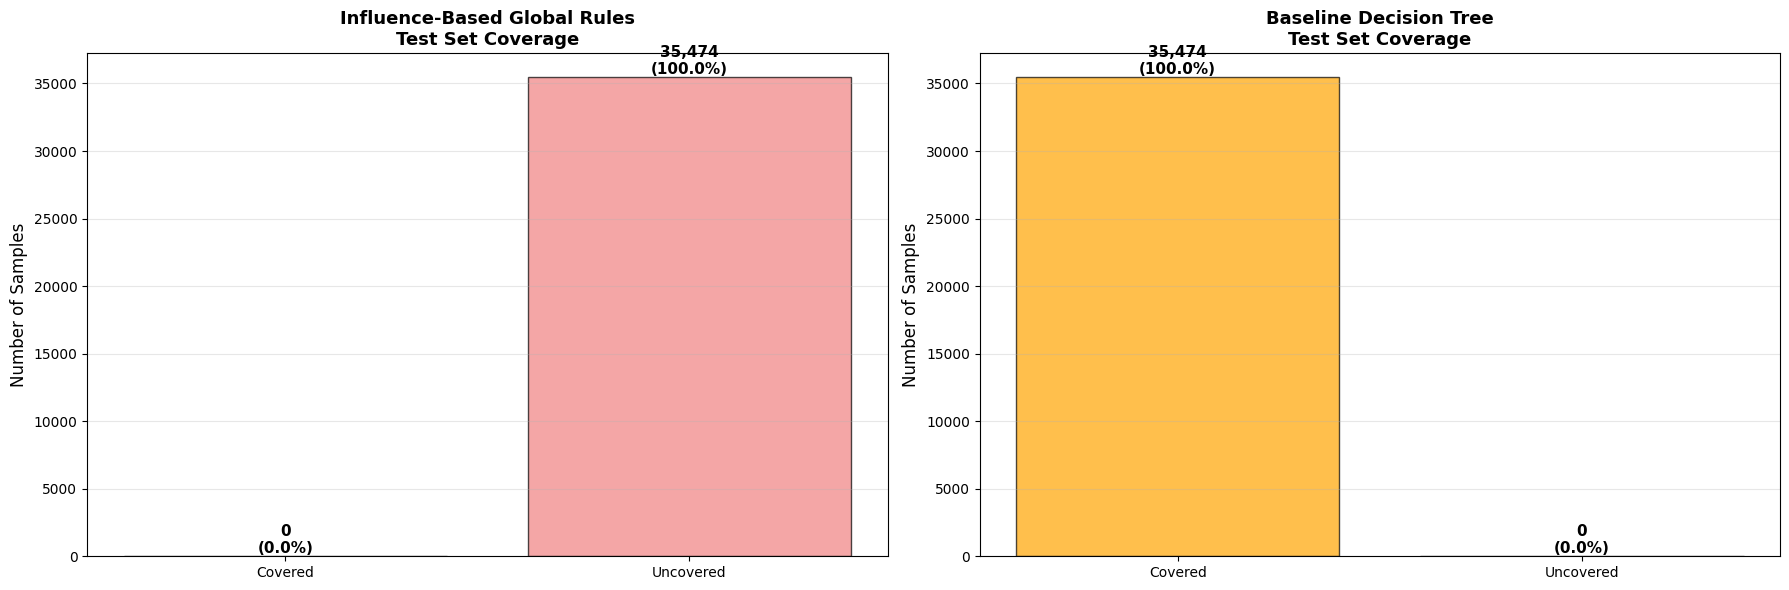


SUMMARY

Metric                                   Influence-Based      LORE->GLocalX        Baseline Tree       
----------------------------------------------------------------------------------------------------
Accuracy (vs True Labels)                0.7558               N/A                  0.6796              
Fidelity (vs TabNet)                     0.5770               N/A                  0.9357              
Coverage                                 0.00               % N/A                  100.00%             
Number of Rules/Nodes                    4                    N/A                  683                 
Avg Conditions per Rule                  1.75                 N/A                  10.00               

✓ Evaluation complete!


In [49]:
# ============================================================================
# Surrogate Tree Evaluation: Global Rules vs Baseline Decision Tree
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("SURROGATE TREE EVALUATION - THREE-WAY COMPARISON")
print("="*80)
print("\nThis section compares:")
print("  1. Influence-Based Global Rules Surrogate (from influence-based local rules)")
print("  2. LORE->GLocalX Surrogate (from LORE local rules aggregated via GLocalX)")
print("  3. Baseline Decision Tree (trained directly on TabNet predictions)")
print("="*80)

# Check prerequisites
if 'global_rules' not in globals() or len(global_rules) == 0:
    print("\n⚠️  ERROR: Global rules not available!")
    print("   Please run the global rule aggregation cell first.")
    raise ValueError("Global rules required for evaluation")

if 'model' not in globals():
    print("\n⚠️  ERROR: TabNet model not available!")
    print("   Please load the trained TabNet model first.")
    raise ValueError("TabNet model required for baseline")

if 'X_test' not in globals() or 'y_test' not in globals():
    print("\n⚠️  ERROR: Test data not available!")
    print("   Please ensure X_test and y_test are defined.")
    raise ValueError("Test data required for evaluation")

if 'features' not in globals():
    print("\n⚠️  ERROR: Feature names not available!")
    print("   Please ensure 'features' variable is defined.")
    raise ValueError("Feature names required")

print(f"\n✓ All prerequisites met!")
print(f"  - Global rules: {len(global_rules)} rules")
print(f"  - Test set size: {len(X_test):,} samples")
print(f"  - Number of features: {len(features)}")

# ============================================================================
# Step 1: Create Global Rules Surrogate Predictor
# ============================================================================

def predict_with_global_rules(global_rules, aggregator, X, feature_names, default_label=None):
    """
    Predict using global rules. For each sample, find the first matching rule
    and return its consequence. If no rule matches, return default_label.
    
    Args:
        global_rules: List of LocalRule objects
        aggregator: GlobalRuleAggregator instance
        X: Input data (n_samples, n_features)
        feature_names: List of feature names
        default_label: Default prediction if no rule matches (defaults to majority class)
    
    Returns:
        predictions: Array of predictions (n_samples,)
        rule_coverage: Array indicating which rule matched each sample (n_samples,)
    """
    n_samples = X.shape[0]
    predictions = np.full(n_samples, -1, dtype=int)
    rule_coverage = np.full(n_samples, -1, dtype=int)
    
    # Determine default label if not provided
    if default_label is None:
        # Use majority class from training data if available
        if 'y_train' in globals():
            default_label = int(np.bincount(y_train).argmax())
        else:
            default_label = 0
    
    # For each sample, find the first matching rule
    for sample_idx in range(n_samples):
        sample = X[sample_idx:sample_idx+1]  # Keep 2D shape
        
        # Check each rule in order
        for rule_idx, rule in enumerate(global_rules):
            coverage = aggregator.coverage(rule, sample)
            if coverage[0]:  # This sample is covered by this rule
                predictions[sample_idx] = rule.consequence
                rule_coverage[sample_idx] = rule_idx
                break
        
        # If no rule matched, use default
        if predictions[sample_idx] == -1:
            predictions[sample_idx] = default_label
            rule_coverage[sample_idx] = -1  # -1 means no rule matched
    
    return predictions, rule_coverage

print("\n" + "="*80)
print("STEP 1: Creating Global Rules Surrogate Predictor")
print("="*80)

# Make predictions with global rules
global_rules_predictions, rule_coverage = predict_with_global_rules(
    global_rules, global_aggregator, X_test, features
)

# Calculate coverage statistics
covered_samples = (rule_coverage >= 0).sum()
coverage_pct = (covered_samples / len(X_test)) * 100

print(f"\nGlobal Rules Surrogate Tree:")
print(f"  Total rules: {len(global_rules)}")
print(f"  Test samples covered: {covered_samples:,} / {len(X_test):,} ({coverage_pct:.2f}%)")
print(f"  Uncovered samples (using default): {len(X_test) - covered_samples:,}")

# ============================================================================
# Step 2: Create LORE->GLocalX Surrogate Tree
# ============================================================================

print("\n" + "="*80)
print("STEP 2: Creating LORE->GLocalX Surrogate Tree")
print("="*80)

try:
    # Import LORE components
    import sys
    lore_path = os.path.join(project_root, "utilities", "LORE_sa-main")
    if lore_path not in sys.path:
        sys.path.append(lore_path)
    
    from lore_sa import TabularGeneticGeneratorLore
    from lore_sa.dataset import TabularDataset
    from lore_sa.bbox.bbox import AbstractBBox
    from lore_sa.rule import Rule, Expression
    import operator
    from numpy import inf
    
    # Create TabNet wrapper for LORE
    class TabNetBBox(AbstractBBox):
        """Wrapper for TabNet to work with LORE"""
        def __init__(self, tabnet_model):
            self.classifier = tabnet_model
        
        def predict(self, sample_matrix):
            """Predict class labels"""
            if isinstance(sample_matrix, list):
                sample_matrix = np.array(sample_matrix)
            if len(sample_matrix.shape) == 1:
                sample_matrix = sample_matrix.reshape(1, -1)
            
            predictions = self.classifier.predict(sample_matrix)
            # Convert to integers if needed
            if hasattr(self.classifier, 'target_mapper') and isinstance(predictions[0], (str, np.str_)):
                reverse_mapper = {v: k for k, v in self.classifier.target_mapper.items()}
                return np.array([reverse_mapper.get(int(p), int(p)) for p in predictions])
            return np.array(predictions, dtype=int)
        
        def predict_proba(self, sample_matrix):
            """Predict class probabilities"""
            if isinstance(sample_matrix, list):
                sample_matrix = np.array(sample_matrix)
            if len(sample_matrix.shape) == 1:
                sample_matrix = sample_matrix.reshape(1, -1)
            
            return self.classifier.predict_proba(sample_matrix)
    
    print("\nSetting up LORE explainer...")
    
    # Create TabNet black box wrapper
    tabnet_bbox = TabNetBBox(model)
    
    # Create TabularDataset from training data
    # We need to create a DataFrame with features and target
    df_for_lore = pd.DataFrame(X_train, columns=features)
    df_for_lore[target] = y_train
    
    # Save to temporary CSV for LORE dataset creation
    temp_csv = os.path.join(project_root, "training", "temp_lore_dataset.csv")
    df_for_lore.to_csv(temp_csv, index=False)
    
    # Create LORE dataset
    lore_dataset = TabularDataset.from_csv(temp_csv, class_name=target)
    lore_dataset.update_descriptor()
    
    # Create LORE explainer
    lore_explainer = TabularGeneticGeneratorLore(tabnet_bbox, lore_dataset)
    
    print("  ✓ LORE explainer created")
    
    # Generate LORE explanations for a sample of test instances
    print("\nGenerating LORE explanations for test instances...")
    n_lore_samples = min(50, len(X_test))  # Use up to 50 test samples for LORE
    lore_test_indices = np.random.choice(len(X_test), size=n_lore_samples, replace=False)
    
    lore_local_rules = []
    lore_explanations = []
    
    for i, test_idx in enumerate(lore_test_indices):
        if (i + 1) % 10 == 0:
            print(f"  Processing {i+1}/{n_lore_samples}...")
        
        try:
            # Get test instance as pandas Series
            test_instance = pd.Series(X_test[test_idx], index=features)
            
            # Generate LORE explanation
            explanation = lore_explainer.explain(test_instance)
            lore_explanations.append((test_idx, explanation))
            
            # Extract factual rule from LORE explanation
            # LORE returns a dict with 'rule' as a dict (from rule.to_dict())
            if explanation and 'rule' in explanation and explanation['rule'] is not None:
                rule_dict = explanation['rule']
                # Get prediction from black box
                bb_pred = tabnet_bbox.predict([X_test[test_idx]])[0]
                
                lore_local_rules.append({
                    'test_id': test_idx,
                    'rule_dict': rule_dict,  # Store dict representation
                    'prediction': bb_pred
                })
        except Exception as e:
            print(f"    Warning: Failed to explain test instance {test_idx}: {e}")
            continue
    
    print(f"  ✓ Generated {len(lore_local_rules)} LORE explanations")
    
    # Convert LORE rules to LocalRule format for GLocalX aggregation
    print("\nConverting LORE rules to GLocalX format...")
    
    from utilities.influence.global_rule_aggregation import LocalRule
    
    lore_local_rules_glocalx = []
    
    for lore_rule_data in lore_local_rules:
        rule_dict = lore_rule_data['rule_dict']
        test_id = lore_rule_data['test_id']
        prediction = lore_rule_data['prediction']
        
        # Extract premises from LORE rule dict
        # LORE rule dict has structure: {'premises': [...], 'consequence': {...}}
        premises_dict = {}
        
        if 'premises' not in rule_dict or len(rule_dict['premises']) == 0:
            continue
        
        for premise in rule_dict['premises']:
            # LORE premise dict has: {'attr': feature_name, 'val': threshold, 'op': operator_string}
            feature_name = premise.get('attr', premise.get('variable', None))
            if feature_name is None or feature_name not in features:
                continue  # Skip if feature not in our feature list
            
            op_str = premise.get('op', '<=')
            threshold = premise.get('val', premise.get('value', None))
            
            if threshold is None:
                continue
            
            # Convert to (lower, upper) format used by LocalRule
            if op_str == '<=':
                # feature <= threshold -> (-inf, threshold]
                if feature_name not in premises_dict:
                    premises_dict[feature_name] = (-inf, threshold)
                else:
                    # Update to intersection
                    old_lower, old_upper = premises_dict[feature_name]
                    premises_dict[feature_name] = (max(old_lower, -inf), min(old_upper, threshold))
            elif op_str == '>':
                # feature > threshold -> (threshold, inf)
                if feature_name not in premises_dict:
                    premises_dict[feature_name] = (threshold, inf)
                else:
                    # Update to intersection
                    old_lower, old_upper = premises_dict[feature_name]
                    premises_dict[feature_name] = (max(old_lower, threshold), min(old_upper, inf))
            elif op_str == '>=':
                # feature >= threshold -> [threshold, inf)
                if feature_name not in premises_dict:
                    premises_dict[feature_name] = (threshold, inf)
                else:
                    old_lower, old_upper = premises_dict[feature_name]
                    premises_dict[feature_name] = (max(old_lower, threshold), min(old_upper, inf))
            elif op_str == '<':
                # feature < threshold -> (-inf, threshold)
                if feature_name not in premises_dict:
                    premises_dict[feature_name] = (-inf, threshold)
                else:
                    old_lower, old_upper = premises_dict[feature_name]
                    premises_dict[feature_name] = (max(old_lower, -inf), min(old_upper, threshold))
        
        # Get consequence (predicted class) from rule dict
        # LORE rule dict has 'consequence': {'attr': 'class', 'val': class_value, 'op': '='}
        consequence = prediction  # Use the black box prediction as default
        
        if 'consequence' in rule_dict:
            cons_dict = rule_dict['consequence']
            if isinstance(cons_dict, dict) and 'val' in cons_dict:
                try:
                    consequence = int(cons_dict['val'])
                except (ValueError, TypeError):
                    consequence = prediction
            elif isinstance(cons_dict, (int, float)):
                consequence = int(cons_dict)
        
        # Ensure consequence is an integer (0 or 1)
        try:
            consequence = int(consequence)
            if consequence not in [0, 1]:
                consequence = prediction  # Fallback to prediction if invalid
        except (ValueError, TypeError):
            consequence = prediction
        
        # Create LocalRule object
        if len(premises_dict) > 0:
            rule_string = f"IF {' AND '.join([f'{k} in [{v[0]:.4f}, {v[1]:.4f}]' for k, v in premises_dict.items()])} THEN class = {consequence}"
            local_rule = LocalRule(
                premises=premises_dict,
                consequence=consequence,
                rule_string=rule_string
            )
            lore_local_rules_glocalx.append(local_rule)
    
    print(f"  ✓ Converted {len(lore_local_rules_glocalx)} LORE rules to LocalRule format")
    
    # Aggregate LORE rules using GLocalX
    print("\nAggregating LORE rules using GLocalX...")
    
    # Import GlobalRuleAggregator
    from utilities.influence.global_rule_aggregation import GlobalRuleAggregator
    
    # Use the same aggregator settings as before
    lore_global_aggregator = GlobalRuleAggregator(
        feature_names=features,
        fidelity_weight=1.0,
        complexity_weight=0.1,
        strict_cut=True
    )
    
    lore_global_rules = lore_global_aggregator.aggregate(
        local_rules=lore_local_rules_glocalx,
        x=X_train,
        y=y_train,
        max_iterations=10
    )
    
    print(f"  ✓ Generated {len(lore_global_rules)} global rules from LORE")
    
    # Create LORE->GLocalX surrogate predictor
    lore_glocalx_predictions, lore_rule_coverage = predict_with_global_rules(
        lore_global_rules, lore_global_aggregator, X_test, features
    )
    
    # Calculate coverage statistics
    lore_covered_samples = (lore_rule_coverage >= 0).sum()
    lore_coverage_pct = (lore_covered_samples / len(X_test)) * 100
    
    print(f"\nLORE->GLocalX Surrogate Tree:")
    print(f"  Total rules: {len(lore_global_rules)}")
    print(f"  Test samples covered: {lore_covered_samples:,} / {len(X_test):,} ({lore_coverage_pct:.2f}%)")
    print(f"  Uncovered samples (using default): {len(X_test) - lore_covered_samples:,}")
    
    # Clean up temporary file
    if os.path.exists(temp_csv):
        os.remove(temp_csv)
    
    lore_glocalx_available = True
    
except ImportError as e:
    print(f"\n⚠️  LORE not available: {e}")
    print("   Skipping LORE->GLocalX surrogate tree")
    print("   Install LORE dependencies or ensure LORE_sa-main is in utilities/")
    lore_glocalx_available = False
    lore_global_rules = []
    lore_glocalx_predictions = None
    lore_rule_coverage = None
    lore_coverage_pct = 0.0
    lore_global_aggregator = None
    
except Exception as e:
    print(f"\n⚠️  Error creating LORE->GLocalX surrogate: {e}")
    import traceback
    traceback.print_exc()
    lore_glocalx_available = False
    lore_global_rules = []
    lore_glocalx_predictions = None
    lore_rule_coverage = None
    lore_coverage_pct = 0.0
    lore_global_aggregator = None

# ============================================================================
# Step 3: Create Baseline Decision Tree from TabNet Predictions
# ============================================================================

print("\n" + "="*80)
print("STEP 3: Creating Baseline Decision Tree from TabNet Predictions")
print("="*80)

# Get TabNet predictions on training data
print("\nGenerating TabNet predictions on training data...")
# TabNetClassifier handles eval mode internally, no need to call model.eval()
# TabNet's predict methods accept numpy arrays directly
tabnet_train_proba = model.predict_proba(X_train)
tabnet_train_pred_raw = model.predict(X_train)

# Convert to integers if needed (TabNet may return mapped labels)
if len(tabnet_train_pred_raw) > 0 and isinstance(tabnet_train_pred_raw[0], (str, np.str_)):
    # Convert back using target_mapper if available
    if hasattr(model, 'target_mapper'):
        reverse_mapper = {v: k for k, v in model.target_mapper.items()}
        tabnet_train_pred = np.array([reverse_mapper.get(int(p), int(p)) for p in tabnet_train_pred_raw])
    else:
        tabnet_train_pred = np.array([int(p) for p in tabnet_train_pred_raw])
else:
    tabnet_train_pred = np.array(tabnet_train_pred_raw, dtype=int)

print(f"  TabNet training predictions shape: {tabnet_train_pred.shape}")
print(f"  TabNet training accuracy: {accuracy_score(y_train, tabnet_train_pred):.4f}")

# Train baseline decision tree on TabNet predictions
print("\nTraining baseline decision tree on TabNet predictions...")
baseline_tree = DecisionTreeClassifier(
    max_depth=10,  # Reasonable depth for interpretability
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42
)

baseline_tree.fit(X_train, tabnet_train_pred)
print(f"  ✓ Baseline tree trained")
print(f"  Tree depth: {baseline_tree.get_depth()}")
print(f"  Number of leaves: {baseline_tree.get_n_leaves()}")

# Get baseline tree predictions on test data
print("\nGenerating TabNet predictions on test data...")
# TabNet's predict methods accept numpy arrays directly
tabnet_test_proba = model.predict_proba(X_test)
tabnet_test_pred_raw = model.predict(X_test)

# Convert to integers if needed (TabNet may return mapped labels)
if len(tabnet_test_pred_raw) > 0 and isinstance(tabnet_test_pred_raw[0], (str, np.str_)):
    # Convert back using target_mapper if available
    if hasattr(model, 'target_mapper'):
        reverse_mapper = {v: k for k, v in model.target_mapper.items()}
        tabnet_test_pred = np.array([reverse_mapper.get(int(p), int(p)) for p in tabnet_test_pred_raw])
    else:
        tabnet_test_pred = np.array([int(p) for p in tabnet_test_pred_raw])
else:
    tabnet_test_pred = np.array(tabnet_test_pred_raw, dtype=int)

baseline_tree_predictions = baseline_tree.predict(X_test)

print(f"  TabNet test predictions shape: {tabnet_test_pred.shape}")
print(f"  Baseline tree test predictions shape: {baseline_tree_predictions.shape}")

# ============================================================================
# Step 4: Evaluate All Three Surrogate Trees
# ============================================================================

print("\n" + "="*80)
print("STEP 4: Evaluating All Three Surrogate Trees")
print("="*80)

# Calculate metrics for Global Rules Surrogate
global_rules_accuracy = accuracy_score(y_test, global_rules_predictions)
global_rules_fidelity = accuracy_score(tabnet_test_pred, global_rules_predictions)

# Calculate metrics for Baseline Tree
baseline_tree_accuracy = accuracy_score(y_test, baseline_tree_predictions)
baseline_tree_fidelity = accuracy_score(tabnet_test_pred, baseline_tree_predictions)

# Calculate metrics for LORE->GLocalX (if available)
if lore_glocalx_available and lore_glocalx_predictions is not None:
    lore_glocalx_accuracy = accuracy_score(y_test, lore_glocalx_predictions)
    lore_glocalx_fidelity = accuracy_score(tabnet_test_pred, lore_glocalx_predictions)
else:
    lore_glocalx_accuracy = 0.0
    lore_glocalx_fidelity = 0.0

# TabNet baseline (upper bound)
tabnet_accuracy = accuracy_score(y_test, tabnet_test_pred)

print("\n" + "-"*80)
print("PREDICTION ACCURACY (vs True Labels)")
print("-"*80)
print(f"TabNet (Oracle):                {tabnet_accuracy:.4f}")
print(f"Influence-Based Global Rules:   {global_rules_accuracy:.4f}")
if lore_glocalx_available:
    print(f"LORE->GLocalX Surrogate:         {lore_glocalx_accuracy:.4f}")
print(f"Baseline Decision Tree:          {baseline_tree_accuracy:.4f}")

print("\n" + "-"*80)
print("FIDELITY (vs TabNet Predictions)")
print("-"*80)
print(f"Influence-Based Global Rules:   {global_rules_fidelity:.4f}")
if lore_glocalx_available:
    print(f"LORE->GLocalX Surrogate:         {lore_glocalx_fidelity:.4f}")
print(f"Baseline Decision Tree:          {baseline_tree_fidelity:.4f}")

# ============================================================================
# Step 5: Detailed Comparison
# ============================================================================

print("\n" + "="*80)
print("STEP 5: Detailed Comparison")
print("="*80)

# Classification reports
print("\n" + "-"*80)
print("INFLUENCE-BASED GLOBAL RULES SURROGATE - Classification Report")
print("-"*80)
print(classification_report(y_test, global_rules_predictions, 
                            target_names=['Reject (0)', 'Approve (1)']))

if lore_glocalx_available and lore_glocalx_predictions is not None:
    print("\n" + "-"*80)
    print("LORE->GLocalX SURROGATE - Classification Report")
    print("-"*80)
    print(classification_report(y_test, lore_glocalx_predictions,
                                target_names=['Reject (0)', 'Approve (1)']))

print("\n" + "-"*80)
print("BASELINE DECISION TREE - Classification Report")
print("-"*80)
print(classification_report(y_test, baseline_tree_predictions,
                            target_names=['Reject (0)', 'Approve (1)']))

# Rule complexity comparison
print("\n" + "-"*80)
print("RULE COMPLEXITY COMPARISON")
print("-"*80)

# Global rules complexity
total_global_conditions = sum(len(rule.features) for rule in global_rules)
avg_global_conditions = total_global_conditions / len(global_rules) if len(global_rules) > 0 else 0

print(f"\nGlobal Rules Surrogate:")
print(f"  Number of rules: {len(global_rules)}")
print(f"  Total conditions: {total_global_conditions}")
print(f"  Average conditions per rule: {avg_global_conditions:.2f}")

print(f"\nBaseline Decision Tree:")
print(f"  Tree depth: {baseline_tree.get_depth()}")
print(f"  Number of leaves: {baseline_tree.get_n_leaves()}")
print(f"  Number of nodes: {baseline_tree.tree_.node_count}")

if lore_glocalx_available and len(lore_global_rules) > 0:
    lore_total_conditions = sum(len(rule.features) for rule in lore_global_rules)
    lore_avg_conditions = lore_total_conditions / len(lore_global_rules) if len(lore_global_rules) > 0 else 0
    
    print(f"\nLORE->GLocalX Surrogate:")
    print(f"  Number of rules: {len(lore_global_rules)}")
    print(f"  Total conditions: {lore_total_conditions}")
    print(f"  Average conditions per rule: {lore_avg_conditions:.2f}")

# ============================================================================
# Step 6: Visualization
# ============================================================================

print("\n" + "="*80)
print("STEP 6: Creating Visualizations")
print("="*80)

# Create comparison plots
n_models = 4 if lore_glocalx_available else 3
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Surrogate Tree Comparison: Three-Way Evaluation', 
             fontsize=16, fontweight='bold')

# 1. Accuracy Comparison
ax1 = axes[0, 0]
if lore_glocalx_available:
    metrics = ['TabNet\n(Oracle)', 'Influence\nGlobal Rules', 'LORE->\nGLocalX', 'Baseline\nDecision Tree']
    accuracies = [tabnet_accuracy, global_rules_accuracy, lore_glocalx_accuracy, baseline_tree_accuracy]
    colors = ['green', 'blue', 'purple', 'orange']
else:
    metrics = ['TabNet\n(Oracle)', 'Influence\nGlobal Rules', 'Baseline\nDecision Tree']
    accuracies = [tabnet_accuracy, global_rules_accuracy, baseline_tree_accuracy]
    colors = ['green', 'blue', 'orange']
bars = ax1.bar(metrics, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Prediction Accuracy (vs True Labels)', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Fidelity Comparison
ax2 = axes[0, 1]
if lore_glocalx_available:
    fidelities = [1.0, global_rules_fidelity, lore_glocalx_fidelity, baseline_tree_fidelity]
else:
    fidelities = [1.0, global_rules_fidelity, baseline_tree_fidelity]
bars2 = ax2.bar(metrics, fidelities, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Fidelity', fontsize=12)
ax2.set_title('Fidelity to TabNet Predictions', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

for bar, fid in zip(bars2, fidelities):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{fid:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Confusion Matrix - Influence-Based Global Rules
ax3 = axes[1, 0]
cm_global = confusion_matrix(y_test, global_rules_predictions)
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Reject', 'Approve'], yticklabels=['Reject', 'Approve'])
ax3.set_title(f'Influence-Based Global Rules\nConfusion Matrix', fontsize=13, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=11)
ax3.set_xlabel('Predicted Label', fontsize=11)

# 4. Confusion Matrix - LORE->GLocalX or Baseline Tree
ax4 = axes[1, 1]
if lore_glocalx_available and lore_glocalx_predictions is not None:
    cm_lore = confusion_matrix(y_test, lore_glocalx_predictions)
    sns.heatmap(cm_lore, annot=True, fmt='d', cmap='Purples', ax=ax4,
                xticklabels=['Reject', 'Approve'], yticklabels=['Reject', 'Approve'])
    ax4.set_title(f'LORE->GLocalX Surrogate\nConfusion Matrix', fontsize=13, fontweight='bold')
else:
    cm_baseline = confusion_matrix(y_test, baseline_tree_predictions)
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Oranges', ax=ax4,
                xticklabels=['Reject', 'Approve'], yticklabels=['Reject', 'Approve'])
    ax4.set_title(f'Baseline Decision Tree\nConfusion Matrix', fontsize=13, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=11)
ax4.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Coverage visualization - Comparison of all methods
fig2, axes = plt.subplots(1, 3 if lore_glocalx_available else 2, figsize=(18, 6))

# Influence-Based Global Rules Coverage
ax1 = axes[0]
rule_coverage_counts = {}
for rule_idx in rule_coverage:
    if rule_idx >= 0:
        rule_coverage_counts[rule_idx] = rule_coverage_counts.get(rule_idx, 0) + 1

covered_by_rule = sum(rule_coverage_counts.values())
uncovered = len(X_test) - covered_by_rule

coverage_data = {
    'Covered': covered_by_rule,
    'Uncovered': uncovered
}

bars1 = ax1.bar(coverage_data.keys(), coverage_data.values(), 
                color=['steelblue', 'lightcoral'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Influence-Based Global Rules\nTest Set Coverage', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(X_test)*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# LORE->GLocalX Coverage (if available)
if lore_glocalx_available and lore_rule_coverage is not None:
    ax2 = axes[1]
    lore_rule_coverage_counts = {}
    for rule_idx in lore_rule_coverage:
        if rule_idx >= 0:
            lore_rule_coverage_counts[rule_idx] = lore_rule_coverage_counts.get(rule_idx, 0) + 1
    
    lore_covered_by_rule = sum(lore_rule_coverage_counts.values())
    lore_uncovered = len(X_test) - lore_covered_by_rule
    
    lore_coverage_data = {
        'Covered': lore_covered_by_rule,
        'Uncovered': lore_uncovered
    }
    
    bars2 = ax2.bar(lore_coverage_data.keys(), lore_coverage_data.values(), 
                    color=['purple', 'lightcoral'], alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Samples', fontsize=12)
    ax2.set_title('LORE->GLocalX Surrogate\nTest Set Coverage', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}\n({height/len(X_test)*100:.1f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Baseline Tree Coverage (always 100%)
    ax3 = axes[2]
    baseline_coverage_data = {
        'Covered': len(X_test),
        'Uncovered': 0
    }
    bars3 = ax3.bar(baseline_coverage_data.keys(), baseline_coverage_data.values(), 
                    color=['orange', 'lightcoral'], alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Number of Samples', fontsize=12)
    ax3.set_title('Baseline Decision Tree\nTest Set Coverage', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}\n({height/len(X_test)*100:.1f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
else:
    # Baseline Tree Coverage (always 100%)
    ax2 = axes[1]
    baseline_coverage_data = {
        'Covered': len(X_test),
        'Uncovered': 0
    }
    bars2 = ax2.bar(baseline_coverage_data.keys(), baseline_coverage_data.values(), 
                    color=['orange', 'lightcoral'], alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Samples', fontsize=12)
    ax2.set_title('Baseline Decision Tree\nTest Set Coverage', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height):,}\n({height/len(X_test)*100:.1f}%)',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

# Summary table
print(f"\n{'Metric':<40} {'Influence-Based':<20} {'LORE->GLocalX':<20} {'Baseline Tree':<20}")
print("-"*100)
print(f"{'Accuracy (vs True Labels)':<40} {global_rules_accuracy:<20.4f} ", end="")
if lore_glocalx_available:
    print(f"{lore_glocalx_accuracy:<20.4f} {baseline_tree_accuracy:<20.4f}")
else:
    print(f"{'N/A':<20} {baseline_tree_accuracy:<20.4f}")

print(f"{'Fidelity (vs TabNet)':<40} {global_rules_fidelity:<20.4f} ", end="")
if lore_glocalx_available:
    print(f"{lore_glocalx_fidelity:<20.4f} {baseline_tree_fidelity:<20.4f}")
else:
    print(f"{'N/A':<20} {baseline_tree_fidelity:<20.4f}")

print(f"{'Coverage':<40} {coverage_pct:<19.2f}% ", end="")
if lore_glocalx_available:
    print(f"{lore_coverage_pct:<19.2f}% {'100.00%':<20}")
else:
    print(f"{'N/A':<20} {'100.00%':<20}")

print(f"{'Number of Rules/Nodes':<40} {len(global_rules):<20} ", end="")
if lore_glocalx_available and len(lore_global_rules) > 0:
    print(f"{len(lore_global_rules):<20} {baseline_tree.tree_.node_count:<20}")
else:
    print(f"{'N/A':<20} {baseline_tree.tree_.node_count:<20}")

print(f"{'Avg Conditions per Rule':<40} {avg_global_conditions:<20.2f} ", end="")
if lore_glocalx_available and len(lore_global_rules) > 0:
    print(f"{lore_avg_conditions:<20.2f} {baseline_tree.get_depth():<20.2f}")
else:
    print(f"{'N/A':<20} {baseline_tree.get_depth():<20.2f}")

print("\n" + "="*80)
print("✓ Evaluation complete!")
print("="*80)
